# Assignment 3

This notebook is the solution to HW3, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [1]:
import nltk, re, itertools
import matplotlib.pyplot as plt
import numpy as np
from nltk import nonterminals, Nonterminal, Production, induce_pcfg
from nltk.parse import generate
from nltk.grammar import Nonterminal, Production, toy_pcfg2
from nltk.probability import DictionaryProbDist
from nltk import Tree, CFG, PCFG, Nonterminal
from nltk.treetransforms import chomsky_normal_form
from numpy import log
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader
from collections import *

Now after doing so we can go ahead and solve the tasks.

## Part 1

In the first part of the assignment we will discuss designing CFG for NLP task.
<br> We were given the following code which read CFGs from string representation, and parse sentences given a CFG using a  a bottom-up parsing algorithm:

In [2]:
sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


### Part 1.1

First, an important note about our parser, the Shift-Reduce parser. This parser does not support ambiguity at all. If multiple reductions are available for a single word, it will simply choose the first reduction listed (and if it fails, it will not go back to try the second reduction). This means we can't have the same NT on the rhs of two different rules.

We're required to support a new list of sentences. In order to explain the process of creating the CFG, we would like to split the sentence list into three different lists (slightly altering the original sentence order). The first list:

John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary

And here's the grammar:

In [3]:
sg = """
S -> DET NP VP | NP VP | PR_NOM VP
NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
VP -> IV | TV NP | TV PR_ACC
TV -> 'eats' | 'loves'
PR_NOM -> 'She' | 'Everybody'
PR_ACC -> 'them'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
"""

sentences = sentences.split("\n")

for i in range(2,7):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV loves) (NP Mary)))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * John]
  R [ PR_NOM TV * John]
  S [ PR_NOM TV 'John' * ]
  R [ PR_NOM TV NP * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (NP John)))
---------
Parsing 'She loves them'
    [ * She loves them]
  S [ 'She' * loves them]
  R [ PR_NOM * loves them]
  S [ PR_NOM 'loves' * them]
  R [ PR_NOM TV * them]
  S [ PR_NOM TV 'them' * ]
  R [ PR_NOM TV PR_ACC * ]
  R [ PR_NOM VP * ]
  R [ S * ]
(S (PR_NOM She) (VP (TV loves) (PR_ACC them)))
---------
Parsing 'Everybody loves John'
    [ * Everybody loves John]
  S [ 'Everybody' * loves John]
  R [ PR_NOM * loves John]
  S [ PR_NOM 'loves' * Joh

This bit was relatively easy to deal with. We've introduced pronouns, who are split (so far) into two categories by their case: Nominative (He, she etc) and accusative (her, them) etc. Nominative pronouns appear in the beginning of sentences, accusative ones in the end. So we've added pronouns as an alternative to NPs in the appropriate places. We've also introduced the category of determiners (only "A" so far), which can start a sentence before a noun ("A book") - note that a determiner can't precede a pronoun ("A she" is not legal).

Our next sentences are a bit different:

They love Mary 

They love her

The difference is the use of 'love' instead of 'loves'. This is a different kind of verb that follows different speakers - "They love" and "He loves" are legal, but "They loves" and "He love" aren't. So we'll split our grammar into two categories - sentences of type 1 (without s), and type 2.

In English, the category 1 is I/we/you/they (in this case, they will all be followed by 'love'), and category 2 is he/she/it (all followed by 'loves'). This separation is somewhat similar to singular/plural, however it is not the same - note that "I" (singluar) is in the same category as "we" and "they" (plural), while "you" can refer to both singluar and plural. So for a lack of better name, we will refer to those categories as categories 1 and 2.

So here's our new grammar:


In [4]:
#1 = I, we, you, they
#2 = He, she, it

sg = """
S -> S1 | S2
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2
VP2 -> IV | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves'
PR_NOM2 -> 'She' | 'Everybody'

NP -> 'John' | 'bread' | 'Mary' | 'boy'
IV -> 'left' 
PR_ACC -> 'them' | 'her'
DET -> 'A'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
"""

sentences = sentences.split("\n")

for i in range(7,9):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'They love Mary'
    [ * They love Mary]
  S [ 'They' * love Mary]
  R [ PR_NOM1 * love Mary]
  S [ PR_NOM1 'love' * Mary]
  R [ PR_NOM1 TV1 * Mary]
  S [ PR_NOM1 TV1 'Mary' * ]
  R [ PR_NOM1 TV1 NP * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (NP Mary))))
---------
Parsing 'They love her'
    [ * They love her]
  S [ 'They' * love her]
  R [ PR_NOM1 * love her]
  S [ PR_NOM1 'love' * her]
  R [ PR_NOM1 TV1 * her]
  S [ PR_NOM1 TV1 'her' * ]
  R [ PR_NOM1 TV1 PR_ACC * ]
  R [ PR_NOM1 VP1 * ]
  R [ S1 * ]
  R [ S * ]
(S (S1 (PR_NOM1 They) (VP1 (TV1 love) (PR_ACC her))))
---------


As you can see, we split most rules into types 1 and 2. Note that accusative pronounes aren't changed - the word "her" will be the same in both "I love her" and "she loves her".
Our last group of sentences is:

John gave Mary a heavy book

John gave it to Mary

This is when we encounter the limitations of the SRP. Looking at the first sentence, "John gave Mary" is already a legal sentence in our grammar (assuming the verb "gave" is added). So once we parse "John gave Mary", before the parser continues to the next word, those words will be reduced to "S". The best solution would be to use a better, less limited parser that supports ambiguity. But sticking with the SR parser, our solution will be a bit untidy - we will simply add a rule that adds the rest of the words after S.

In [5]:
sg = """
S -> S1 | S2 | S DET AD_NP | S PREP_NP
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love'
PR_NOM1 -> 'They'

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2 | 
VP2 -> IV2 | TV2 NP | TV2 PR_ACC
TV2 -> 'eats' | 'loves' | 'gave'
PR_NOM2 -> 'She' | 'Everybody'
IV2 -> 'left'

NP -> 'John' | 'bread' | 'Mary' | 'boy' | 'book'
AD_NP -> ADJ NP
PREP_NP -> PREP NP
PR_ACC -> 'them' | 'her' | 'it'
PREP -> "to"
DET -> 'A' | 'a'
ADJ -> 'heavy'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

Note: the use of infinite recursion causes NLTK to throw some warnings - however they are false, as all sentences are parsed (and clearly all roles are used).

Let's verify all 11 sentences are parsed correctly:

In [6]:
sentences = """John left
John eats bread
John loves Mary
She loves John
She loves them 
Everybody loves John
A boy loves Mary
They love Mary 
They love her
John gave Mary a heavy book
John gave it to Mary"""

'''
Number: singular / plural (e.g., he/they)
Gender: masculine / feminine / neutral (e.g., he/she/it)
Case: nominative / accusative (e.g., he/him)
'''

sentences = sentences.split("\n")

for i in range(11):
    parse_sentence(sentences[i])
    print("---------")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV2 * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (IV2 left))))
---------
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV2 * bread]
  S [ NP TV2 'bread' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 eats) (NP bread))))
---------
Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV2 * Mary]
  S [ NP TV2 'Mary' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
---------
Parsing 'She loves John'
    [ * She loves John]
  S [ 'She' * loves John]
  R [ PR_NOM2 * loves John]
  S [ PR_NOM2 'loves' * John]
  R [ PR_NOM2 TV2 * John]
  S [ PR_NOM2 TV2 'John' * ]
  R [ PR_NOM2 TV2 NP * ]
  R

As for gender: we didn't need to encode it, because gender doesn't make a grammatical difference in English. Most pronouns (I/we/you/they) are netural to gender. And he/she, the only pronouns who are specific to a gender, behave the same gramatically ("he loves her", "she loves her"). The same also goes for nouns who have a clear gender ("John loves her", "Mary loves her").

#### Part 1.1.2

Our grammar isn't perfect, and it does overgenerate in certain cases. One weakness is the lack of separation between different nouns, even though certain nouns can't logically do certain actions. This allows us to parse illogical sentences, such as:

In [7]:
parse_sentence("bread gave book a heavy Mary")

Parsing 'bread gave book a heavy Mary'
    [ * bread gave book a heavy Mary]
  S [ 'bread' * gave book a heavy Mary]
  R [ NP * gave book a heavy Mary]
  S [ NP 'gave' * book a heavy Mary]
  R [ NP TV2 * book a heavy Mary]
  S [ NP TV2 'book' * a heavy Mary]
  R [ NP TV2 NP * a heavy Mary]
  R [ NP VP2 * a heavy Mary]
  R [ S2 * a heavy Mary]
  R [ S * a heavy Mary]
  S [ S 'a' * heavy Mary]
  R [ S DET * heavy Mary]
  S [ S DET 'heavy' * Mary]
  R [ S DET ADJ * Mary]
  S [ S DET ADJ 'Mary' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP bread) (VP2 (TV2 gave) (NP book))))
  (DET a)
  (AD_NP (ADJ heavy) (NP Mary)))


Another weakness is the workaround we've added for the last sentences, which basically allows us to add certain combinations (such as DET ADJ NP) at the end of every sentence:

In [8]:
parse_sentence("John loves Mary a heavy book")

Parsing 'John loves Mary a heavy book'
    [ * John loves Mary a heavy book]
  S [ 'John' * loves Mary a heavy book]
  R [ NP * loves Mary a heavy book]
  S [ NP 'loves' * Mary a heavy book]
  R [ NP TV2 * Mary a heavy book]
  S [ NP TV2 'Mary' * a heavy book]
  R [ NP TV2 NP * a heavy book]
  R [ NP VP2 * a heavy book]
  R [ S2 * a heavy book]
  R [ S * a heavy book]
  S [ S 'a' * heavy book]
  R [ S DET * heavy book]
  S [ S DET 'heavy' * book]
  R [ S DET ADJ * book]
  S [ S DET ADJ 'book' * ]
  R [ S DET ADJ NP * ]
  R [ S DET AD_NP * ]
  R [ S * ]
(S
  (S (S2 (NP John) (VP2 (TV2 loves) (NP Mary))))
  (DET a)
  (AD_NP (ADJ heavy) (NP book)))


And since the role is recursive, we can add it as many times as we like:

In [9]:
parse_sentence("John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book")

Parsing 'John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book'
    [ * John loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ 'John' * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP * loves Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP 'loves' * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 * Mary a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  S [ NP TV2 'Mary' * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP TV2 NP * a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book a heavy book]
  R [ NP VP2 * a heavy book a heavy book a heavy book a heavy book a heavy book a h

### Part 1.2

So now we're expected to add support to these sentences:

John saw a man with a telescope
John saw a man on the hill with a telescope

Mary knows men and women
Mary knows men, children and women

John and Mary eat bread
John and Mary eat bread with cheese

We can keep using the same trick from the end of last question - a recursive role to allow us to add certain suffixes at the end of a legal sentence (potentially endlessley). For example: if "John saw a man" is a legal sentence in our language, we can add two possible suffixes after it: "on the hill" and "with a telescope". This will make all combinations legal - many of them makes sense ("John saw a man with a telescope" "...man on the hill" "...man on the hill with a telescope" "...man with a telescope on the hill"), but also, as we've seen in the last question, we're exposed to infinite loops.

Here is the new grammar:

In [11]:
sg = """
S -> S1 | S2 | S DET AD_NP | S PREP_NP | S PREP DET_NP | S CONJ_NP
S1 -> PR_NOM1 VP1
VP1 -> TV1 NP | TV1 PR_ACC
TV1 -> 'love' | 'eat'
PR_NOM1 -> 'They' | NP CONJ NP

S2 -> DET NP VP2 | NP VP2 | PR_NOM2 VP2 | 
VP2 -> IV2 | TV2 NP | TV2 PR_ACC | TV2 DET_NP
TV2 -> 'eats' | 'loves' | 'gave' | 'saw' | 'knows'
PR_NOM2 -> 'She' | 'Everybody'
IV2 -> 'left'

NP -> 'John' | 'bread' | 'Mary' | 'boy' | 'book' | 'man' | 'telescope' | 'hill' | 'men' | 'women' | 'children' | 'cheese'
AD_NP -> ADJ NP
PREP_NP -> PREP NP
DET_NP -> DET NP
CONJ_NP -> CONJ NP
PR_ACC -> 'them' | 'her' | 'it'
PREP -> "to" | 'with' | 'on'
DET -> 'A' | 'a' | 'the'
CONJ -> 'and' | ','
ADJ -> 'heavy'
"""

g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

In [12]:
# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = re.findall(r"[\w']+|[.,!?;]", sent)
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

sentences = """John saw a man with a telescope
John saw a man on the hill with a telescope
Mary knows men and women
Mary knows men, children and women
John and Mary eat bread
John and Mary eat bread with cheese"""


sentences = sentences.split("\n")

for i in range(6):
    parse_sentence(sentences[i])
    print ("---------")

Parsing 'John saw a man with a telescope'
    [ * John saw a man with a telescope]
  S [ 'John' * saw a man with a telescope]
  R [ NP * saw a man with a telescope]
  S [ NP 'saw' * a man with a telescope]
  R [ NP TV2 * a man with a telescope]
  S [ NP TV2 'a' * man with a telescope]
  R [ NP TV2 DET * man with a telescope]
  S [ NP TV2 DET 'man' * with a telescope]
  R [ NP TV2 DET NP * with a telescope]
  R [ NP TV2 DET_NP * with a telescope]
  R [ NP VP2 * with a telescope]
  R [ S2 * with a telescope]
  R [ S * with a telescope]
  S [ S 'with' * a telescope]
  R [ S PREP * a telescope]
  S [ S PREP 'a' * telescope]
  R [ S PREP DET * telescope]
  S [ S PREP DET 'telescope' * ]
  R [ S PREP DET NP * ]
  R [ S PREP DET_NP * ]
  R [ S * ]
(S
  (S (S2 (NP John) (VP2 (TV2 saw) (DET_NP (DET a) (NP man)))))
  (PREP with)
  (DET_NP (DET a) (NP telescope)))
---------
Parsing 'John saw a man on the hill with a telescope'
    [ * John saw a man on the hill with a telescope]
  S [ 'John' * sa

A few specific notes about implementation:

-We've added the category of conjuction, such as 'and'.

-The 4th sentence includes a comma, which also has a grammatical role. However, the split function previously used does not split punctuation (it created the word 'men,' rather than 'men' and ','), so we've changed the split method to a method that will split the coma (using regular expressions). The comma is treated as a conjuction word, similar to 'and' - again, the endless recursion helps us to add two suffixes (", children" "and women") on top of "Mary knows".

-The expression "John and Mary" is equivalent to "they", so it's treated as a nominative pronoun.


#### Part 1.2.2

Looking at the given examples and the number of coordination:

"John and Mary" - 2 people

"John or Mary" - 1 people

"John or the children" - either one or an unspecified (bigger than 1) number of people.

The first example was already dealt with in the last question - by treating "NP and NP" as equivalent to "They".
The case of 'or' is a bit more complicated, because it can refer to either singular or plural, as the last two examples show. One of the weaknesses of our grammar (as we demonstrate in the next question), is not separating singluar and plural nouns. So a possible solution to deal with the problem is to separate the category NP into NP_PL and NP_SIN (plural and singular). After we split it, we can safely treat "NP_PL or NP_PL" as plural (similar to "they"), and "NP_SIN or NP_SIN" as singluar (similar to he/she). 

The mixed case, "NP_PL or NP_SIN" is still ambiguous - but this is not a problem with our grammar, but with the English language. When we say 'John or the children', we don't know whether we're talking about singluar or plural. The correct grammar in those cases is the singluar grammar - "John or the children love him" (rather than "loves"), so we can treat the mix case as similar to 'They'.

#### Part 1.2.3

Neither of the issues we pointed out on the previous question are now fixed. We're still prone to illogical nouns use ("telescope eats a children with boy on a John" parses ok) and still prone to endlessley stacking sentences on top of each other. 
Some of our new added NPs ("women", "men") are plural - meaning swapping them with a singluar NP is problematic. For example, 'Mary knows women' makes sense, but "Mary knows hill" is gramatically wrong - we would have needed a determiner ("Mary knows **a** hill") to create a correct sentence.

In [13]:
parse_sentence ("Mary knows hill")

Parsing 'Mary knows hill'
    [ * Mary knows hill]
  S [ 'Mary' * knows hill]
  R [ NP * knows hill]
  S [ NP 'knows' * hill]
  R [ NP TV2 * hill]
  S [ NP TV2 'hill' * ]
  R [ NP TV2 NP * ]
  R [ NP VP2 * ]
  R [ S2 * ]
  R [ S * ]
(S (S2 (NP Mary) (VP2 (TV2 knows) (NP hill))))


A new problem is introduced with conjuction - our conjuction role treats the comma sign and the word 'and' in the same way. Which means we can create a list with any combination of those. Of course, English grammar demands each item on the list to be comma separated, while "and" only appears before the last item ("a, b, c and d"). This example breaks both roles:

In [14]:
parse_sentence ("Mary knows men and children and book and telescope and hill, boy, John")

Parsing 'Mary knows men and children and book and telescope and hill , boy , John'
    [ * Mary knows men and children and book and telescope and hill , boy , John]
  S [ 'Mary' * knows men and children and book and telescope and hill , boy , John]
  R [ NP * knows men and children and book and telescope and hill , boy , John]
  S [ NP 'knows' * men and children and book and telescope and hill , boy , John]
  R [ NP TV2 * men and children and book and telescope and hill , boy , John]
  S [ NP TV2 'men' * and children and book and telescope and hill , boy , John]
  R [ NP TV2 NP * and children and book and telescope and hill , boy , John]
  R [ NP VP2 * and children and book and telescope and hill , boy , John]
  R [ S2 * and children and book and telescope and hill , boy , John]
  R [ S * and children and book and telescope and hill , boy , John]
  S [ S 'and' * children and book and telescope and hill , boy , John]
  R [ S CONJ * children and book and telescope and hill , boy , John]


## Part 2

### Part 2.1

NLTK has a model called generate which is able to generate sentences given a CFG grammer. 
Our goal in this part is to create a generator for a PCFG instead of a CFG.

So lets start by writing our generator function, which, given a PCFG, return a tree representing the generation process:

In [15]:
# generates a tree from a PCFG grammer 
def pcfg_generate(grammar):
    start = grammar.start()
    return(pcfg_generate_root(grammar, start))
    
# generates a tree from a given root based on the PCFG grammer    
def pcfg_generate_root(grammar, root):
    #if it's not a terminal it means we have to generate from the probabilities
    if isinstance(root, Nonterminal):
        item_productions = grammar.productions(lhs=root)
        dict = {}
        for pr in item_productions: dict[pr.rhs()] = pr.prob()
        item_probDist = DictionaryProbDist(dict)
        prod = item_probDist.generate()
        if (len(prod) == 2):
            lh = prod[0]
            rh = prod[1]
            lh_tree = pcfg_generate_root(grammar, lh)
            rh_tree = pcfg_generate_root(grammar, rh)
            return Tree(root, [lh_tree, rh_tree])
        else:
            lh = prod[0]
            return Tree(root,[pcfg_generate_root(grammar, lh)])
           
    #if it's a terminal we can just return it
    else:
        return root

Now we can test our function with the *toy_pcfg2* grammer:

In [3]:
example_tree = pcfg_generate(toy_pcfg2)
Tree.fromstring(example_tree.pformat()).pretty_print()

                                                                S                                                              
                            ____________________________________|_______                                                        
                           |                                            VP                                                     
                           |                                         ___|________                                               
                           |                                        |            NP                                            
                           |                                        |        ____|_________                                     
                           NP                                       |       |              PP                                  
      _____________________|_________                               |       |          ____|_________

As we can see, not all the resulting sentences makes sense... This might be due to the fact the PCFG is based on distribution, and therefore it will always lean towards certain phrases. 

We will now continue on to do some validations in the next subsections - 

#### Part 2.1.1

The first thing we are going to do is to generate 1000 random trees given the *toy_pcfg2* grammer, and save all resulting trees into a file called "toy_pcfg2.gen"

In [16]:
def create_trees_file(n=1000):
    for i in range(n):
        current_tree = pcfg_generate(toy_pcfg2)
        with open("toy_pcfg2.gen", "a+") as f:
            current_tree.pprint(stream=f)
            f.write("*")

In [17]:
create_trees_file(n=1000)

Now once we created such file we can use it to conduct some experiments on the resulting trees.

#### Part 2.1.2

The first thing we need to do is to read our trees from our file:

In [18]:
read_file = open("toy_pcfg2.gen", "r")
buffer = ""
for line in read_file :
    buffer += line
trees = buffer.split("*")
trees = trees[:len(trees) - 1]

Now that we have our trees, we would like to compute the frequency distribution of each non-terminal and pre-terminal in the generated corpus - to do so the first thing we're going to need is the tree's productions:

In [19]:
toy_sample_productions = []
for tree in trees:
    toy_sample_productions += Tree.fromstring(tree).productions()

Once we have those we can calculate the distribution of each non-terminal and pre-terminal, because it's the same as the productions distributions.

When using NLTK we found there are two ways of doing so, one is using native functions in the NLTK library, and the other is to implement it by ourselves. We will demonstrate both and use that fact to evaluate our own function.

The first way, using NLTK native function, is as follows:

In [8]:
#One way of achieving our goal
pcfg_induced = induce_pcfg(Nonterminal('S'), toy_sample_productions).productions()

The second way is to use ConditionalFreqDist for every left-hand and right-hand side of the production, and then create a ConditionalProbDist using MLE (like we did in the previous assignemnts), this will also result in the distribution.

In [9]:
def calc_productions_probabilities(productions):
    #And another way
    cfd = nltk.ConditionalFreqDist((production.lhs(), production.rhs()) for production in productions)
    cpd_mle = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd_mle

now if we compare the distributions from both methods:

In [10]:
toy_sample_probability = calc_productions_probabilities(toy_sample_productions)

In [11]:
print("First Method:")
for nt in pcfg_induced:
    print(nt)
print("\nSecond Method:")
for cond in toy_sample_probability:
    for sample in toy_sample_probability[cond].samples():
        print("{} -> {} {}".format(cond, sample, toy_sample_probability[cond].prob(sample)))

First Method:
S -> NP VP [1.0]
NP -> Name [0.271959]
Name -> 'Jack' [0.538021]
VP -> V NP [0.610505]
V -> 'ran' [0.25]
NP -> Det N [0.408717]
Det -> 'the' [0.394995]
N -> 'telescope' [0.151795]
NP -> NP PP [0.319324]
PP -> P NP [1.0]
P -> 'with' [0.63045]
V -> 'ate' [0.55]
Det -> 'my' [0.286725]
N -> 'hill' [0.498368]
P -> 'under' [0.36955]
N -> 'cookie' [0.126224]
VP -> V [0.380575]
Det -> 'a' [0.318281]
Name -> 'Bob' [0.461979]
N -> 'table' [0.129489]
V -> 'saw' [0.2]
N -> 'boy' [0.094124]
VP -> VP PP [0.00891972]

Second Method:
S -> (NP, VP) 1.0
NP -> (Name,) 0.2719590838336669
NP -> (Det, N) 0.40871692239270624
NP -> (NP, PP) 0.31932399377362686
Name -> ('Jack',) 0.5380212591986917
Name -> ('Bob',) 0.46197874080130824
VP -> (V, NP) 0.6105054509415263
VP -> (V,) 0.38057482656095143
VP -> (VP, PP) 0.008919722497522299
V -> ('ran',) 0.25
V -> ('ate',) 0.55
V -> ('saw',) 0.2
Det -> ('the',) 0.39499455930359084
Det -> ('my',) 0.2867247007616975
Det -> ('a',) 0.3182807399347116
N -> ('t

And as we can see the results are the same (give or take rounding).

After we calculated the distribution for our toy sample, we can calculate them for the entire **toy_pcfg2** grammar, we will use the results in the next section:

In [12]:
toy_pcfg_probability = calc_productions_probabilities(toy_pcfg2.productions())

#### Part 2.1.3

What we would like to calculate next is a measure called **KL Divergence**.
<br>The *Kullback–Leibler divergence*(also called relative entropy) is a measure for how much one probability distribution differ from another.
<br> In order to do so we will consider two distributions,
<br> $P = (x_1: p_1, x_2: p_2, \dots , x_n: p_n)$ and $Q = (y_1: q_1, y_2: q_2, \dots, y_n: q_n)$ such that $\Sigma{p_i} = 1$ and $\Sigma{q_i} = 1$
<br>The KL Divergence is then defined as:
<br>$KL(P,Q) = \Sigma_{i=1, \dots, n} {p_i * \log{\frac{p_i}{q_i}}}$

One can notice this calculation is somewhat problematic because it assumes some things which aren't always correct:
- Both $P$ and $Q$ are defined over the same outcomes $x_i$ 
- We never face $q_i = 0$ for some $i$ or $p_i = 0$ for some $i$

One way of facing that is to decide $0 * \log{0} = 0$ but this only help when $p_i = 0$ or both $p_i = 0$ and $q_i = 0$, so in the case when $p_i \neq 0$ and $q_i = 0$ we define the difference as infinite. 

This method of dealing with those issue might work in some cases and calculations, but in our case $P$ and $Q$ are derived from observations and sample counting - that is, $P$ and $Q$ are probability distributions derived from frequency distributions. We have to therfore take into account some things that might happen:
- there is a big chance for unseen events - meaning samples that appear in one probability but not the other.
- Because of that we can't define the difference as infinite.

In order to deal with that issue, we have to implement a *smoothing* technique on the measure.

A quick way of applying a smoothing over the measure is to use a method called *absolute discounting*.
<br> Absolute discounting would work in our case as follows:
- We define a small cconstant $\epsilon$ (for example $\epsilon = 0.0001$)
- Define $SP = {a, b, c}$ the samples observed in $P$
- Define $CP = |SP| = 3$, the number of samples observed in $P$
- Similarly, $SQ = {a, b, d}$ and $CQ = 3$
- Define $SU = SP U SQ = {a, b, c, d}$ - all the observed samples and $CU = |SU| = 4$

After we define all of this terms, we can them modify our probabilities (smooth) as follows:
- let $pc = \epsilon * \frac{|SU-SP|}{|SP|}$ and $qc = \epsilon * \frac{|SU-SQ|}{|SQ|}$
- for each $p_i$ :
 - let $p'_i = p_i - pc$ if $i\in{SP}$
 - let $p'_i = \epsilon$ otherwise
- similarly for $q'_i$ with $qc$

After we do so, we never get a 0 probability because each probability is defined by it's relative part in the sample(smoothing). and so now we can calculate $KL(P', Q')$ without getting infinite difference.

After defining the smoothing technique we can go ahead and implement the function in python. Since we need to compare our samples to the actual probabilities (which we have no sample for), we'll take a different apporach. We'll convert both to list of rules, with each rule being represented as a dictionary of (lhs, rhs, prob):

In [23]:
sample_dict = []
for cond in toy_sample_probability:
    for sample in toy_sample_probability[cond].samples():
        sample_dict.append({"lhs": str(cond), "rhs":str(sample), "prob":toy_sample_probability[cond].prob(sample)})
    
actual_dict = []    
prods = toy_pcfg2.productions()
for p in prods:
    actual_dict.append({"lhs":str(p.lhs()), "rhs":str(p.rhs()), "prob":p.prob()})

We'll work with the dictionaries, and apply smoothing directly to the probabilities.

In [24]:
def look_in_dict(rule, dictionary, e, e2):
#check by rhs only. e is the value to return if not found
    for d in dictionary:
        if rule.get("rhs") == d.get("rhs"):
            return d.get("prob") - e2
    return e

def get_rules_by_lhs(rules, lhs):
    ans = []
    for r in rules:
        if r.get("lhs") == lhs:
            ans.append(r)
    return ans

def compute_kl_divergence_dict(p, q, eps=0.00001):
# note: KLDivergence isn't symmetrical. 
# We only check smoothing for items in p but not in q (which would result in div by 0). Opposite isn't checked
    kl = 0
    rhs1 = [x.get("rhs") for x in p]
    rhs2 = [x.get("rhs") for x in q]
    diff = len(set(rhs1) - set(rhs2)) #all values in list1, but not list2
    if diff > 0: #we need smoothing
        e = eps / abs(diff) #used as prob for missing values
        e2 = eps / len(p) #subtract from all probs
        for rule in p:
            qi = look_in_dict(rule, q, e, e2)
            pi = rule.get("prob")
            kl +=  pi * log(pi / qi)
    else: #no smoothing
        for rule in p:
            qi = look_in_dict(rule, q, 0, 0)
            pi = rule.get("prob")
            kl +=  pi * log(pi / qi)
    return kl

And now we would like to apply it to our two probability distributions (one is our toy sample and one is the original toy test grammar):

In [25]:
lefts = set([x.get('lhs') for x in sample_dict])
divergence = {}
for lhs in lefts:
    p_rules = get_rules_by_lhs(sample_dict, lhs)
    q_rules = get_rules_by_lhs(actual_dict, lhs)
    kl = compute_kl_divergence_dict(p_rules, q_rules)
    divergence[lhs] = kl

print("Divergence:", divergence)

Divergence: {'N': 0.0018510145319563156, 'V': 0.003438949718842718, 'PP': 0.0, 'Name': 0.0006513413232086401, 'VP': 0.0008923461108814382, 'S': 0.0, 'Det': 0.00046774191971986345, 'P': 0.0008847882882358944, 'NP': 0.0002574245574358362}


We will analyze the results in the next section. 

#### Part 2.1.4

It seems the results are very low and similar. For some tags, the KL divergence is 0, which means the distributions are identical. This happens in cases where a non-terminal can only lead to one rhs derivation. So the probablility for this rhs is 1.0, and our sample will always choose it (as it's the only option), so the calculated prob will also be 1.0. For example, S only has one rule - it will always lead to NP VP. So the probability of S -> NP VP is 1.0 in both cases, hence the divergence is 0.

The difference begins when we have more than one possible derivations. Why is there a difference? Because our sample is limited to only 1000 generated tress, there is no guarantee that the probabilities that we've calculated based on the sample are identical to the actual probabilties. This idea is similar to a coin toss - each option has a probability of 0.5, but if we flip a coin n times, we won't neccesserily get both head and tails n/2 times. The higher the n is, the closer we'll be to the actual probability - 1000 is fairly high, so we get quite close. But still the probabilities aren't identical.

### Part 2.2

What we'd like to do now is to explore how we can induce a PCFG from a given treebank.
<br>To do so we would use the Penn Treebank given by NLTK. 

#### Part 2.2.1

The first thing we'd like to do is to induce the PCFG from the original treebank without transforming it into a CNF.

The Penn Treebank comes with some additional information for the tags, for example some NP tags has additional information like NP-<> where <> indicates something about the words(for example object), we don't need this information in our induction (it actually might mess up the results, because each NP tag then will be considered seperately and this will mess the probabilities). 
<br>Another thing it holds is some NONE tags, used for "missing" words.

We don't want to take NONE tags into account in our induced PCFG, so a suggested method is to ignore all NONE tags (just remove their branch from the tree).

Lets implement a function that simplifies a tag then:

In [26]:
def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    # -NONE- tag
    if "" == tag:
        return " "
    return tag

Now after we did so we can use this function to create all productions given a tree. 

In [20]:
def get_tag(tree):
    if isinstance(tree, Tree):
        simplified_tag = simplify_functional_tag(tree.label())
        # -NONE- tag
        if simplified_tag == " ":
            return " "
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    # if the root is NONE we don't need to parse it more
    if(" " == get_tag(tree)):
        return
    else:
        return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                if prod:
                    yield prod

Once we get all the productions of a given tree, all we have to do is to induce a PCFG from those productions, to so do we will use NLTK function called **induce_pcfg**, what this function does is-

For each production **A -> B C** in a list of productions the probability of it in a PCFG is
<br>$P(B, C|A) = \frac{count(A -> B C)}{count(A -> *)}$ so it's the relation between how many times we've seen *A -> B C* compared to all the possible rules for *A*.

So implementing it in python we get:

In [21]:
def pcfg_learn(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

In [22]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')

#### Part 2.2.1

The first thing we'd like to do is to examine the tree bank a little bit. We'd like to see how many internal nodes are in it, and how many productions are in it (we shall do so for 200 trees and not the entire treebank)

In [30]:
def count_productions(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    return len([prod for prod in trees_productions])

In [31]:
def count_tree_nodes(tree):
    if isinstance(tree, Tree):
        child_nodes = 0.0
        for child in tree:
            child_nodes += count_tree_nodes(child)
        return(1 + child_nodes)
    else:
        # leave
        return 0

def count_internal_nodes(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_internals = 0.0
    for tree in trees:
        trees_internals += count_tree_nodes(tree)
    return trees_internals

In [32]:
print("Number of productions:", count_productions(treebank, 200))
print("Number of internals:", count_internal_nodes(treebank, 200))

Number of productions: 8692
Number of internals: 9020.0


As we can see, there's a slight difference, that might be due to the fact we haven't removed the NONE tags from the internal node counts, so lets see how many NONE tags are in there:

In [33]:
def count_nones_in_tree(tree):
    if isinstance(tree, Tree):
        tree_tag = tree.label()
        child_nodes = 0.0
        if("NONE" in tree_tag):
            child_nodes = 1        
        for child in tree:
            child_nodes += count_nones_in_tree(child)
        return(child_nodes)
    else:
        # leave
        return 0

def count_none(treebank, n):
    trees = treebank.parsed_sents()[:n]
    none_trees_count = 0.0
    for tree in trees:
        none_trees_count += count_nones_in_tree(tree)
    return none_trees_count

In [34]:
print("Number of nones:", count_none(treebank, 200))

Number of nones: 328.0


And as expected all the "missing" productions are for the "NONE" elements. 
<br> this result fits what we learned in class - the number of internal nodes is equal to the number of productions

#### Part 2.2.2

Instead of doing what we did in the previous section , we don't want to build a pcfg now, we just to look at the frequencies, so what we will do is build a freqDist

In [35]:
def pcfg_freq(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        trees_productions += [prod for prod in productions]
    pcfg_freq = Counter(trees_productions)
    return pcfg_freq

We want to examine the frequencies on 200 trees from the treebank:

In [36]:
two_hundred_trees_freq = pcfg_freq(treebank, 200)

Lets plot the distribution of productions according to their frequency:

In [37]:
def plot_distributions(tree_freq, fignum):
    _, counts = zip(*tree_freq.items())
    counts = (list(counts))
    counts.sort()

    labels, values = zip(*Counter(counts).items())
    indexes = np.arange(len(labels))


    plt.figure(num=fignum, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, 1.5)
    plt.xticks(indexes, labels)
    plt.show()

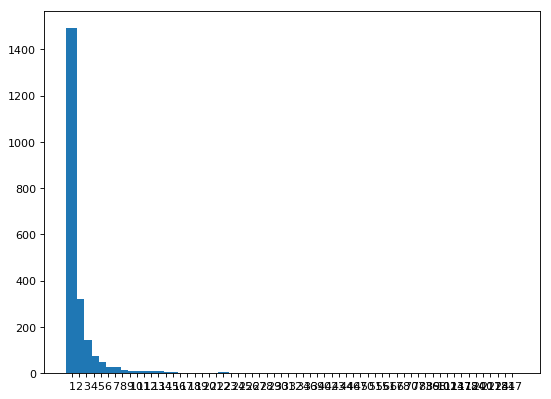

In [38]:
plot_distributions(two_hundred_trees_freq, 3)

As we can see, most productions appear only once, it is very rare for a production to appear over 10 times for example. This makes sense considering Penn Treebank is based on paper articles which has a very diverse English, so the productions would be unique.

#### Part 2.2.3

We now want to see how the results vary between indctions based on the amount of data, to do so we will induct the pcfg from 200 trees and from 400 trees:

In [41]:
two_hundred_trees_pcfg = pcfg_learn(treebank, 200)
four_hundred_trees_pcfg = pcfg_learn(treebank, 400)

In the previous section we introduced a measure called KL divergence to determine how divert are the results, so lets use it here to check how much the results differ between the inductions:

In [42]:
two_hundred_dict = []    
two_hundred_prods = two_hundred_trees_pcfg.productions()
for p in two_hundred_prods:
    two_hundred_dict.append({"lhs":str(p.lhs()), "rhs":str(p.rhs()), "prob":p.prob()})

four_hundred_dict = []    
four_hundred_prods = four_hundred_trees_pcfg.productions()
for p in four_hundred_prods:
    four_hundred_dict.append({"lhs":str(p.lhs()), "rhs":str(p.rhs()), "prob":p.prob()}) 

In [43]:
lefts_two_hundred = set([x.get('lhs') for x in two_hundred_dict])
divergence_t_f = {}
for lhs in lefts_two_hundred:
    p_t_rules = get_rules_by_lhs(two_hundred_dict, lhs)
    q_f_rules = get_rules_by_lhs(four_hundred_dict, lhs)
    kl_t_f = compute_kl_divergence_dict (p_t_rules, q_f_rules)
    divergence_t_f[lhs] = kl_t_f

print("Divergence:", divergence_t_f)

Divergence: {'WDT': 0.10223661166954814, 'WHNP': 0.044440639497006426, 'POS': 0.0015083686251935076, 'VP': 0.12325849419798066, '``': 0.02105340919783248, 'SBAR': 0.03829365031480552, 'SINV': 0.21936276547002642, 'WRB': 0.13809589840931158, 'VB': 0.4501997286772666, 'FRAG': 1.3862943611198906, 'PRN': 0.653181815877547, 'CC': 0.022649024059560294, 'PRT': 0.044451762570833796, 'ADVP': 0.11657443307757961, 'NN': 0.36843576773994174, 'IN': 0.04325952021960926, 'WP$': 0.0, 'S': 0.04659959317804459, '.': 0.007490671729157659, 'RP': 0.1879744673371177, ':': 0.0566695754126886, 'NNPS': 0.5941261547656673, 'VBN': 0.5564981307759392, 'NNP': 0.44655317331976907, 'EX': 0.010309643601367866, 'WP': 0.07130369095859772, 'RRC': 0.0, '$': 0.024391453124159048, 'CONJP': 0.4054651081081644, 'DT': 0.03462172303821177, 'PP': 0.019370905774959014, 'WHADVP': 0.27825378937318634, 'VBZ': 0.21559193903701576, 'VBG': 0.5851248031274122, 'PRP$': 0.06902872834015468, 'CD': 0.284500350007232, 'JJS': 0.2044325592573

**#TODO** - compare

### Part 2.3

Now instead of calculating the PCFG of a simple treebank, we'd like to calculate it for a CNF treebank.

The first thing we need to do before transforming a tree into a CNF tree, is to simplify the tree - meaning get rid of NONE tags and simplify the tags.
<br>We treat a NONE brunch as a brunch we can remove from the tree because it leads no where.
<br>The code below simplifies a tree:

In [23]:
def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    # -NONE- tag
    if "" == tag:
        return " "
    return tag

def get_tag_clean(tree):
    if isinstance(tree, Tree):
        simplified_tag = simplify_functional_tag(tree.label())
        return simplified_tag

def build_simplified_tree(tree):
    if isinstance(tree, Tree):
        root_tag = get_tag_clean(tree)
        if(" " == root_tag):
            return " "
        else:
            simplified_child_nodes = [build_simplified_tree(child) for child in tree]
            # remove all NONE children
            simplified_children = [child for child in  simplified_child_nodes if child != " "]
            if(len(simplified_children) >= 1):
                return(Tree(root_tag, simplified_children))
            else:
                # This means the only child is NONE so we can remove it from it's parent as well
                return " "
    else:
        return tree

After we do so we just have to turn a tree into production (notice we don't have to handle the NONE cases anymore as our tree is clear of them).

In [24]:
def get_tag_or_value(tree):
    if isinstance(tree, Tree):
        return Nonterminal(tree.label())
    else:
        return tree
        
def cnf_tree_to_production(tree):
    return Production(get_tag_or_value(tree),[get_tag_or_value(child) for child in tree])

def cnf_tree_to_productions(tree):
    yield cnf_tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in cnf_tree_to_productions(child):
                if prod:
                    yield prod

Now after setting up the functions to all stages, letse set it all together to induce a PCFG from a CFG treebank - 
The stages are, for each tree in the treebank:
- Simplify the tree and rid of NONE tags.
- Transform the tree into a CNF tree.
- Induce the productions from the CNF tree.

In [25]:
def pcfg_cnf_learn(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions = cnf_tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

In [47]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_cnf = two_hundred_trees_pcfg = pcfg_cnf_learn(treebank, 200)

We want to show the number of productions in the CNF treebank - so we get:

In [48]:
print("The number of productions:", len(pcfg_cnf.productions()))

The number of productions: 2797


We've seen earlier that in the original treebank we had 8692 internal nodes, now we have 2797 productions, but these are unique productions, to find out exactly how many productions we have (not only unique ones) lets count the amount of internal nodes in the CNF treebank:

In [49]:
def pcfg_cnf_internals(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_internals = 0.0
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        trees_internals += count_tree_nodes(new_tree)
    return trees_internals

In [50]:
print("Internal nodes/ number of productions:", pcfg_cnf_internals(treebank, 200))

Internal nodes/ number of productions: 10038.0


So we can see turning it into a CNF added more productions(and internal nodes) over all. This makes sense considering a CNF tree is usally bigger than the non-CNF tree (each rule in a none CNF tree which expand to more than 2 child will result in a lot of additional rules).

We have a relation of $\frac{10038}{8692} = 1.154855$ which means on average we have more than 1 to 1 relation between productions, and that is because, as we just said, bigger productions gets broken apart to smaller rules.

### Part 2.4

What we'd like to do now is to explore the CFG hypothesis that a node expansion is independent from its location within a tree.
<br>We will do so by exploring the expansion of the NP category in thr CNF trees.

The first thing we'd like to do is show how the NP's RHS and LHS distributed , meaning for each LHS show the distribution of it's RHS. to do so we will look at each NP tag in the treebank and see it's production.

In [27]:
def get_np_productions(treebank, n):
    trees = treebank.parsed_sents()[:n]
    np_productions = []
    for tree in trees:
        productions = tree_to_productions(tree)
        for prod in productions:
            if(prod.lhs() == Nonterminal('NP')):
                np_productions += [(prod.rhs())]
    return np_productions

In [28]:
np_productions = get_np_productions(treebank, 200)

Now that we have the productions we's like to look at an histogram of them, to do so we will use the counter object.

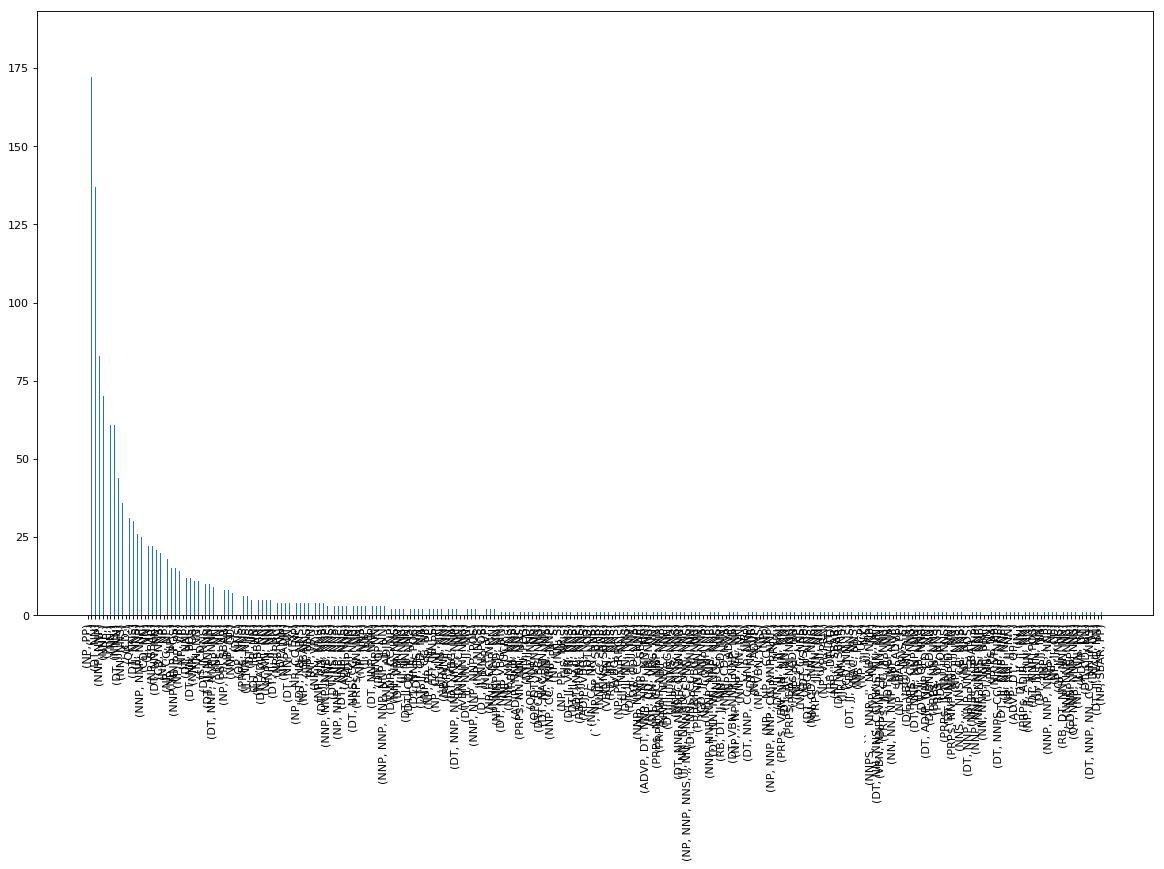

In [53]:
counter = Counter(np_productions)
counts = counter.most_common()

ind = [count for key, count in counts]
bins = range(0, len(counts))
bins = [bin * 5 for bin in bins]

keys = [key for key, count in counts]

plt.figure(num=6, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(bins, ind , align='edge', width=1)
plt.xticks(bins, keys, rotation='vertical')
plt.show()

Now we'd like to to see what is the distribution of NP that comes after S, to so we need to get all NP productions after an S:

In [29]:
def tree_to_np_under_x_productions(x, tree, is_child):
    productions = []
    if isinstance(tree, Tree):
        if(get_tag(tree) == Nonterminal(x)):
            for child in tree:
                productions += tree_to_np_under_x_productions(x, child, True)
            return productions
        elif(get_tag(tree) == Nonterminal('NP') and is_child):
            productions += [Production(get_tag(tree), [get_tag(child) for child in tree])]  
        for child in tree:
            productions += tree_to_np_under_x_productions(x, child, False) 
    return productions
    
    
def get_np_s_production(treebank, n):
    trees = treebank.parsed_sents()[:n]
    np_s_productions = []
    for tree in trees:
        np_s_productions += tree_to_np_under_x_productions('S', tree, False)
    np_s_productions = [prod.rhs() for prod in np_s_productions]
    return np_s_productions

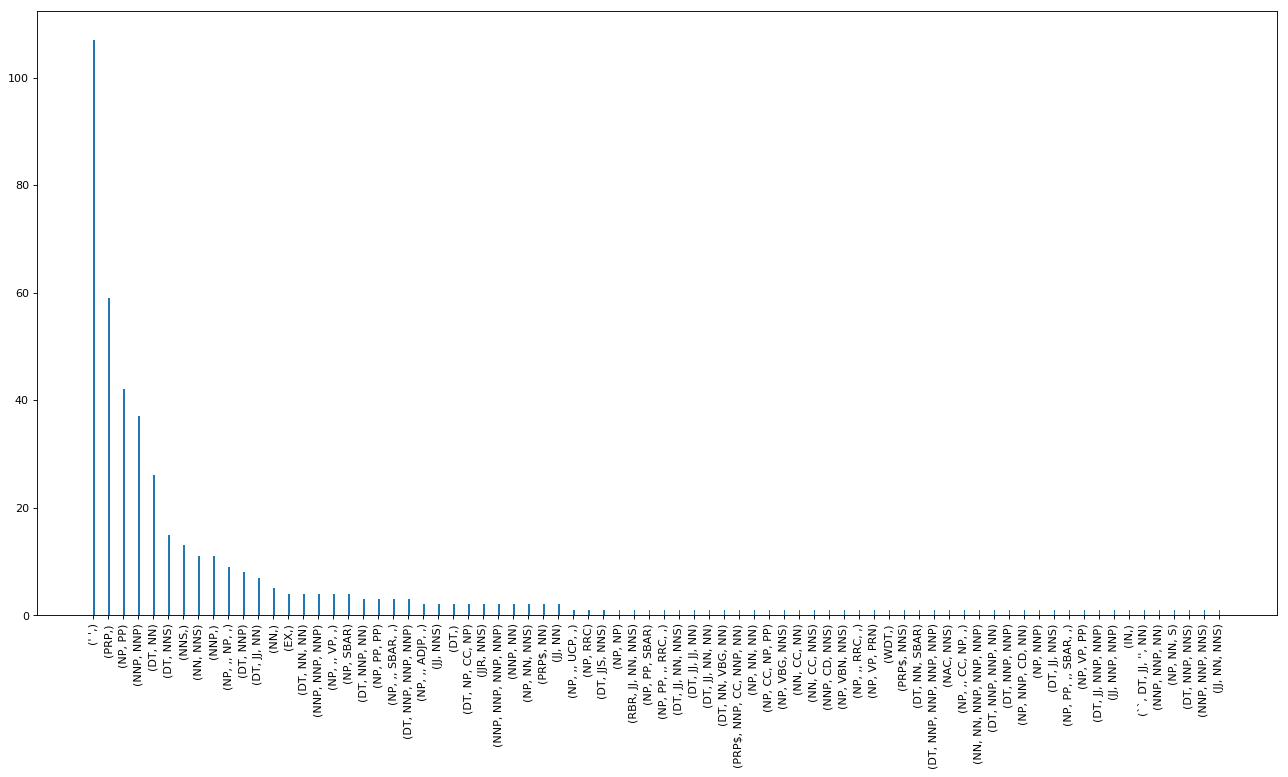

In [30]:
np_s_productions = get_np_s_production(treebank, 200)
counter_s_np = Counter(np_s_productions)
counts_s_np = counter_s_np.most_common()

ind_s_np = [count for key, count in counts_s_np]
bins_s_np = range(0, len(counts_s_np))
bins_s_np = [bin * 10 for bin in bins_s_np]
keys_s_np = [key for key, count in counts_s_np]

plt.figure(num=7, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(bins_s_np, ind_s_np , align='edge', width=1)
plt.xticks(bins_s_np, keys_s_np, rotation='vertical')
plt.show()

And now lets do the same for 'VP' tags:

In [31]:
def get_np_vp_production(treebank, n):
    trees = treebank.parsed_sents()[:n]
    np_vp_productions = []
    for tree in trees:
        np_vp_productions += tree_to_np_under_x_productions('VP', tree, False)
    np_vp_productions = [prod.rhs() for prod in np_vp_productions]
    return np_vp_productions

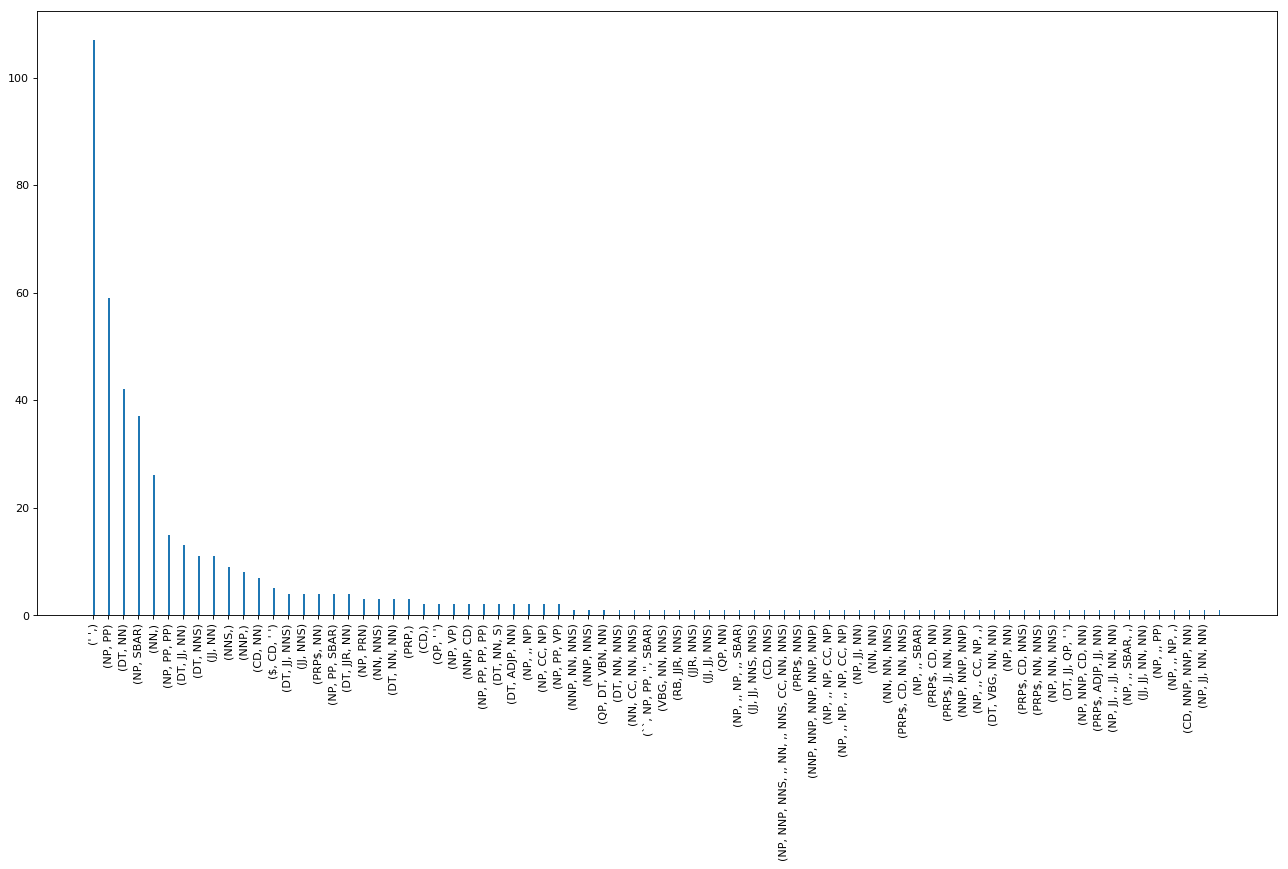

In [32]:
np_vp_productions = get_np_vp_production(treebank, 200)
counter_vp_np = Counter(np_vp_productions)
counts_vp_np = counter_vp_np.most_common()

ind_vp_np = [count for key, count in counts_vp_np]
bins_vp_np = range(0, len(counts_vp_np))
bins_vp_np = [bin * 10 for bin in bins_vp_np]
keys_vp_np = [key for key, count in counts_vp_np]

plt.figure(num=7, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(bins_s_np, ind_s_np , align='edge', width=1)
plt.xticks(bins_vp_np, keys_vp_np, rotation='vertical')
plt.show()

Now what we'd like to do is to compare those distributions, so lets first turn all of the frequency plots into proper distributions:

In [33]:
np_freq = nltk.ConditionalFreqDist((Nonterminal('NP'), prod) for prod in np_productions)
np_s_freq = nltk.ConditionalFreqDist((Nonterminal('NP'), prob) for prob in np_s_productions)
np_vp_freq = nltk.ConditionalFreqDist((Nonterminal('NP'), prob) for prob in np_vp_productions)

np_probs = nltk.ConditionalProbDist(np_freq, nltk.MLEProbDist)
np_s_probs = nltk.ConditionalProbDist(np_s_freq, nltk.MLEProbDist)
np_vp_probs = nltk.ConditionalProbDist(np_vp_freq, nltk.MLEProbDist)

And now we'd like to compare each pair using KL-Divergence, using a different method (now we only have probabilities and not samples):

In [34]:
def compute_kl_divergence(p, q, eps=0.0001):
    sp = list(p.samples())
    cp = len(sp)
    sq = list(q.samples())
    cq = len(sq)
    su = set(sp + sq)
    pc = eps * ((cq) / float(cp))
    qc = eps * ((cp) / float(cq))
    kl = 0.0
    for i in su:
        if i in sp:
             p_i = p.prob(i) - pc
        else:
            p_i = eps
        if i in sq:
            q_i = q.prob(i) - qc
        else:
            q_i = eps
        kl +=  p_i * log(p_i / float(q_i))
    return kl

def compute_divergence_np(prob_a, prob_b):
    divergence_np = {}
    for condition in prob_a.conditions():
        kl_np_s = compute_kl_divergence(prob_a[condition], prob_b[condition])
        divergence_np[condition] = kl_np_s
    return(divergence_np)

Lets start by comparing the entire treebank to the ones starting with s:

In [35]:
compute_divergence_np(np_probs, np_s_probs)

{NP: 0.8949599316917198}

In [36]:
compute_divergence_np(np_probs, np_vp_probs)

{NP: 0.8407276785131196}

We notice the numbers are fairly high - despite one of the distributions being a subset of the other (all the NPs that appear after an S/VP node, are a subset of all NPs).
Let's compare the NPs that appear after S and the ones that appear after VP:
Note: KL-Divergene isn't a symmetrical, so we'll try both directions.

In [62]:
compute_divergence_np(np_s_probs, np_vp_probs)

{NP: 1.4684558651039554}

In [63]:
compute_divergence_np(np_vp_probs, np_s_probs)

{NP: 1.2549563530563899}

We notice the numbers are really high, compared to any KL-divergence we've seen so far (and found on the internet). The conclusion is that those distributions aren't very similar. This conclusion contradicts the CFG hypothesis (which expects the distribution for an NT to be indentical, regardless of it's position within a tree), meaning our trees aren't CFGs.
How can we explain this conclusion? Our trees were diverted from PTB's treebank - which means they were diverted from actual sentences in the English language. The English language itself is very complicate, and isn't neccesserily context-free. It makes  sense that NPs that appear in certain positions in the sentence (such as right at the beginning), are likely to have different distributions from NPs that appear elsewhere, as their role and position in the sentence is different.

## Part 3

In this part of the assignment we will construct a viterbi parser for the previously induced PCFG and then evaluate it.

### Part 3.1 - building the parser

#### Part 3.1.1

Before we go ahead and build a parser, we need to set up our training data and our test data, to do so we will split the Penn Treebank into two parts - the training corpus will contain 80% of the trees, and the testing corpus will contain the other 20%.

Before we do so, lets explore the treebank so we know the length each set should be:

In [37]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
trees = treebank.parsed_sents()
total = len(trees)
eighty_pr = int(total * 0.8)
twenty_pr = int(total * 0.2)
print("80%: ", eighty_pr)
print("20%: ", twenty_pr)

80%:  3131
20%:  782


As we can see, the split fits the division from the question - about 3200 train trees and about 800 test trees.

So now we know the exact size each should have, and we can write functions to get each:

In [38]:
def get_data(divider, end):
    treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
    trees_start = treebank.parsed_sents()[:divider]
    trees_end = treebank.parsed_sents()[divider : end - 1]
    return trees_start, trees_end

In [39]:
train_set, test_set = get_data(3131, 3131 + 782)

#### Part 3.1.2

The next thing we'd like to do is to learn a PCFG over the Chomsky Normal Form version of the treebank. 
To do so we will use the functions from part 2 and the training set size as the *n* input.

In [40]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_training = pcfg_cnf_learn(treebank, 3131)

#### Part 3.1.3

Now once we have a PCFG we can finally construct a **Viterbi Parser** for our treebank. 
To do so we will use NLTK native function to build such parser, and we will feed it with our PCFG.

In [41]:
v_parser = nltk.ViterbiParser(pcfg_training)

Now lets test our parser on a few example sentences:

In [42]:
sent = 'any country is fine , as long as you know how to drive'.split()
p = v_parser.parse(sent)
for t in p:
    print(t)

(S
  (NP^<S> (DT any) (NN country))
  (VP^<S>
    (VBZ is)
    (VP|<ADVP>^<S>
      (ADVP^<VP>
        (RB fine)
        (ADVP|<,>^<VP>
          (, ,)
          (ADVP|<RB>^<VP> (RB as) (RB long))))
      (SBAR^<VP>
        (IN as)
        (S^<SBAR>
          (NP^<S> (PRP you))
          (VP^<S>
            (VBP know)
            (SBAR^<VP>
              (WHADVP^<SBAR> (WRB how))
              (S^<SBAR>
                (VP^<S> (TO to) (VP^<VP> (VBP drive))))))))))) (p=1.10745e-41)


And another few:

In [43]:
sent = 'we saw a big hill and we climbed on top of it'.split()
p = v_parser.parse(sent)
for t in p:
    print(t)

(S
  (NP^<S> (PRP we))
  (VP^<S>
    (VBD saw)
    (SBAR^<VP>
      (S^<SBAR>
        (NP^<S>
          (NP^<NP>
            (DT a)
            (NP|<JJ>^<NP> (JJ big) (NN hill)))
          (NP|<CC>^<S> (CC and) (PRP we)))
        (VP^<S>
          (VBD climbed)
          (VP|<PP>^<S>
            (PP^<VP> (IN on) (NP^<PP> (NN top)))
            (PP^<VP> (IN of) (NP^<PP> (PRP it))))))))) (p=1.93607e-39)


In [44]:
sent = "it does not take much to be happy , you just need to try".split()
p = v_parser.parse(sent)
for t in p:
    print(t)

(S
  (S^<S>
    (NP^<S> (PRP it))
    (VP^<S>
      (VBZ does)
      (VP|<RB>^<S>
        (RB not)
        (VP^<VP>
          (VB take)
          (ADJP^<VP>
            (JJ much)
            (S^<ADJP>
              (VP^<S>
                (TO to)
                (VP^<VP> (VB be) (ADJP^<VP> (JJ happy))))))))))
  (S|<,>
    (, ,)
    (S|<NP>
      (NP^<S> (PRP you))
      (S|<ADVP>
        (ADVP^<S> (RB just))
        (VP^<S>
          (VBP need)
          (S^<VP> (VP^<S> (TO to) (VP^<VP> (VB try))))))))) (p=3.58749e-40)


As we can see, the sentences we chose have very low probabilities. This makes sense considering this treebank is composed out of journalism articles, and those sentences aren't very "journalistic". So let's try a few more journalistic sentence:

In [46]:
sent = "many banks are turning away from strict price competition".split()
p = v_parser.parse(sent)
for t in p:
    print(t)

(S
  (NP^<S> (JJ many) (NNS banks))
  (VP^<S>
    (VBP are)
    (VP^<VP>
      (VBG turning)
      (VP|<PRT>^<VP>
        (PRT^<VP> (RP away))
        (PP^<VP>
          (IN from)
          (NP^<PP>
            (JJ strict)
            (NP|<NN>^<PP> (NN price) (NN competition)))))))) (p=1.12595e-30)


And as we can see it is actually more likely than the others.

One important problem is that this parser can't deal with unknown words:

In [47]:
sent = 'big cat'.split()
p = v_parser.parse(sent)
try:
    for t in p:
        print(t)
except ValueError as e:
    print(e)

Grammar does not cover some of the input words: "'cat'".


This might be a problem if our test set and train set for example don't have the same exact vocabulary, so let's check that:

In [48]:
training_vocab = set({})
for tree in train_set:
    words = tree.leaves()
    for word in words:
        training_vocab.add(word)
    
test_vocab = set({})
for tree in test_set:
    words = tree.leaves()
    for word in words:
        test_vocab.add(word)

In [49]:
print("training_vocab", len(training_vocab))
print("testing_vocab", len(test_vocab))

training_vocab 11044
testing_vocab 4089


So we can clearly see there are a lot of words in the training that are not in the test dataset (this will also be useful later), but those words aren't the problematic cases. Our problem is words that appear in the test dataset, but not the train, so let's look at the intersection of the sets: 

In [52]:
print(len(training_vocab.intersection(test_vocab)))

2725


so we have $4071-2712 = 1359$ words that are in the test set, but not in the train set.
<br>In order to deal with those words, we will add grammer rules to deal with such words - to do so we will use their POS tag (like we learned in class).

In [53]:
in_test = (test_vocab - training_vocab)
print(len(in_test))

1364


First thing we will do is to convert the words to rules based on the POS tagging. A thing to note about that is that nltk pos tagger uses the univeral tagset, but our parser uses ptb tagset, so we need to convert the tags after figuring out the tag for our word, so lets start building up our rules(we will later construct them into productions):

In [54]:
def get_ptb_tag(word):
    return nltk.pos_tag([word])

In [55]:
pos_tags = []
for word in in_test:
    pos_tags += get_ptb_tag(word)

Now we need to construct productions from those rules:

In [56]:
pos_productions = []
for tag in pos_tags:
    pos_productions += [Production(Nonterminal(tag[1]), [tag[0]])]

So now we have a list of all the prductions for the missing words, and we need to somehow insert them into our grammer.

To do so we will modify out pcfg generator function:

In [57]:
def pcfg_cnf_learn_with_productions(treebank, n, additional_productions):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions = cnf_tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    trees_productions += additional_productions
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

And now we will construct a viterbi parser with the additional POS productions:

In [58]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_pos_training = pcfg_cnf_learn_with_productions(treebank, 3131, pos_productions)
v_pos_parser = nltk.ViterbiParser(pcfg_pos_training)

Now lets test our parser on a word in the test trees which isn't in the train trees - to do so we will find such word:

In [62]:
word = in_test.pop()
print(word)

thieves


and as we can see the word *thieves* is in the test set but not in the train set, if we use the old parser we defined we will get an error:

In [63]:
sent = 'they are thieves'.split()
p = v_parser.parse(sent)
try:
    for t in p:
        print(t)
except ValueError as e:
    print(e)

Grammar does not cover some of the input words: "'thieves'".


But using our new parser we get:

In [64]:
sent = 'they are thieves'.split()
p = v_pos_parser.parse(sent)
try:
    for t in p:
        print(t)
except ValueError as e:
    print(e)

(S
  (NP^<S> (PRP they))
  (VP^<S> (VBP are) (NP^<VP> (NNS thieves)))) (p=3.12926e-12)


And as we can see, we managed to parse the tree.

### Part 3.2

After writing the Viterbi parser, the next thing we'd like to do is to determine how well it preforms, to do so we will use the trusty old measure we defined in the previous assignment - Precision, Recall and Fscore, but a modified version of them.

What we'd like to is to evaluate them in two methods:
- unlabeled: comparing first and last index, regardless of the label.
- labeled: comparing both the label and the indices.

The mentioned index refers to the index which is part of the constituents. 
<br>A constituent is a triplet of the form *(interior node, index of the first word in the sentence covered by it, index of the last word in the sentence covered by it)*.

**Labeled Precision** is therfore defined as the average of how many brackets
in the resulting parse tree match those in the actual tree. we measure it by: 
$LP = \frac{Correct Constituents Parse S}{Total Constituents Parse S}$

**Labeled Recall** is the average of how many brackets in the actual tree are in the resulting parse tree, and we measure it by:
$LR = \frac{Correct Constituents Parse S}{Total Constituents Reference Parse S}$

The F-Measure stays same as before - an harmonic average of precision and recall.

The first thing we need to do then is given a tree - we want to build it's constituents:

In [65]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]

def parse_inner_labels(tree, final_tags, prev_tags, list_of_consts):
    if(isinstance(tree, Tree)):
        if(tree.label() in final_tags):
            return prev_tags
        else:
            child_indices = []
            p_t = prev_tags
            for child in tree:
                child_indices.append([parse_inner_labels(child, final_tags, p_t, list_of_consts)])
                p_t += len(child.pos())
            child_indices = flatten(child_indices)
            list_of_consts.append((tree.label(), child_indices[0], child_indices[len(child_indices) - 1] + 1))
            return child_indices

def build_constituents(tree):
    tagged_words = tree.pos()
    final_tags = [b for (a, b) in tagged_words]
    leaves = tree.leaves()
    list_or_consts = []
    parse_inner_labels(tree, final_tags, 0, list_or_consts)
    return list_or_consts

And we will test our function using the examples in the assignment on parsing evaluation by *Scott Farrar*:

In [66]:
parse_tree = Tree(Nonterminal('S') ,[Tree(Nonterminal('NP'),[Tree(Nonterminal('A'), ["a"])]), Tree(Nonterminal('VP'), [Tree(Nonterminal('B') ,["b"]), Tree(Nonterminal('PP'), [Tree(Nonterminal('C'), ["c"])])])])
consts = build_constituents(parse_tree)
print(consts)
second_parse_tree = Tree(Nonterminal('S'), [Tree(Nonterminal('NP'), [Tree(Nonterminal('A'), ["a"])]), Tree(Nonterminal('VP'), [Tree(Nonterminal('B') ,["b"])] ), Tree(Nonterminal('PP') ,[Tree(Nonterminal('C'), ["c"])])])
consts_two = build_constituents(second_parse_tree)
print(consts_two)

[(NP, 0, 1), (PP, 2, 3), (VP, 1, 3), (S, 0, 3)]
[(NP, 0, 1), (VP, 1, 2), (PP, 2, 3), (S, 0, 3)]


We should also test it with a bit more challenging trees, for example one that has the same word in few different locations(and therfore under different rules), for example if we take the tree

In [67]:
parse_tree = Tree(Nonterminal('S'), [Tree(Nonterminal('CC'), ['But']), Tree(Nonterminal('NP'), [Tree(Nonterminal('NN'), ['revenue'])]), Tree(Nonterminal('VP'), [Tree(Nonterminal('VBD'), ['declined']), Tree(Nonterminal('PP'), [Tree(Nonterminal('TO') ,['to']), Tree(Nonterminal('NP'), [Tree(Nonterminal('QP'), [Tree(Nonterminal('$'), ['$']), Tree(Nonterminal('CD'), ['3']), Tree(Nonterminal('CD'), ['billion'])])])]), Tree(Nonterminal('PP'), [Tree(Nonterminal('IN'), ['from']), Tree(Nonterminal('NP'), [Tree(Nonterminal('QP'), [Tree(Nonterminal('$'), ['$']), Tree(Nonterminal('CD'), ['3.2']), Tree(Nonterminal('CD'), ['billion'])])])])]), Tree(Nonterminal('.'), ['.'])])
parse_tree.pprint()
print(parse_tree.leaves())

(S
  (CC But)
  (NP (NN revenue))
  (VP
    (VBD declined)
    (PP (TO to) (NP (QP ($ $) (CD 3) (CD billion))))
    (PP (IN from) (NP (QP ($ $) (CD 3.2) (CD billion)))))
  (. .))
['But', 'revenue', 'declined', 'to', '$', '3', 'billion', 'from', '$', '3.2', 'billion', '.']


We can see "$" shows up two times in different index - one time at 4 and one time at 8, so we should be able to see that in our constituents as well, meaning we should see 'QP' derived to (4, 7) once and to (8, 11) once.

In [68]:
consts = build_constituents(parse_tree)
print(consts)

[(NP, 1, 2), (QP, 4, 7), (NP, 4, 7), (PP, 3, 7), (QP, 8, 11), (NP, 8, 11), (PP, 7, 11), (VP, 2, 11), (S, 0, 12)]


And as we can see it does handle both cases differently.

The next thing we'll do is write functions which calculates both labeled and unlabeled precision and recall:

In [69]:
def calc_labeled_precision(parse_tree_constituents, actual_tree_constituents):
    total_constituents = len(parse_tree_constituents)
    total_correct = 0
    for constituent in parse_tree_constituents:    
        if(constituent in actual_tree_constituents):
            total_correct += 1
    return(total_correct / float(total_constituents))

In [70]:
def calc_labeled_recall(parse_tree_constituents, actual_tree_constituents):
    total_constituents_gold = len(actual_tree_constituents)
    total_correct = 0.0
    for constituent in actual_tree_constituents:
        if(constituent in parse_tree_constituents):
            total_correct += 1
    return(total_correct / float(total_constituents_gold))    

And for the unlabeled version we need to check just if the indices match:

In [71]:
def calc_unlabeled_precision(parse_tree_constituents, actual_tree_constituents):
    total_constituents = len(parse_tree_constituents)
    total_correct = 0.0
    pt_indx = [(i, j) for label, i, j in parse_tree_constituents]
    at_indx = [(i, j) for label, i, j in actual_tree_constituents]
    for indxs in at_indx:
        if indxs in pt_indx:
            total_correct += 1
    return(total_correct / float(total_constituents))

In [72]:
def calc_unlabeled_recall(parse_tree_constituents, actual_tree_constituents):
    total_constituents_gold = len(actual_tree_constituents)
    total_correct = 0.0
    pt_indx = [(i, j) for label, i, j in parse_tree_constituents]
    at_indx = [(i, j) for label, i, j in actual_tree_constituents]
    for indxs in at_indx:
        if indxs in pt_indx:
            total_correct += 1
    return(total_correct / float(total_constituents_gold))

We also need to define the functions for Fscore(like in the previous assignment):

In [73]:
def calc_fscore(precision, recall):
    return(2 * ((precision * recall) / (precision + recall)))

And after defining the measures all we have to do is use them in order to evaluate our parser on the test dataset - we'll try it first with just the first tree:

In [74]:
def parse_first_tree(test_set, parser):
    for tree in test_set:
        simplified = build_simplified_tree(tree)
        sentence = simplified.leaves()
        chomsky_normal_form(simplified, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        actual_tree_constituents = build_constituents(simplified)
        viterbi_parsed = parser.parse(sentence)
        for t in viterbi_parsed:
            parsed_tree_constituents = build_constituents(t)
            l_p = calc_labeled_precision(parsed_tree_constituents, actual_tree_constituents)
            l_r = calc_labeled_recall(parsed_tree_constituents, actual_tree_constituents)
            u_p = calc_unlabeled_precision(parsed_tree_constituents, actual_tree_constituents)
            u_r = calc_unlabeled_recall(parsed_tree_constituents, actual_tree_constituents)
            print("labeld precision", l_p)
            print("labeled recall", l_r)
            print("unlabeled precision", u_p)
            print("unlabeled recall", u_r)
            print("labeled fscore", calc_fscore(l_p, l_r))
            print("labeled fscore", calc_fscore(u_p, u_r))
        break

In [129]:
parse_first_tree(test_set, v_pos_parser)

labeld precision 0.48
labeled recall 0.5217391304347826
unlabeled precision 0.68
unlabeled recall 0.7391304347826086
labeled fscore 0.4999999999999999
labeled fscore 0.7083333333333334


This code does work, but running it takes about 15 minutes which is really bad considering we want to run this over the entire treebank.
<br>There are a few reasons for that
- As we learned in class the parsing time takes $O(n^{3}|R|)$ where *R* is the set of rules.
- We're running our code on CFG trees, which in general have more rules than the original trees, so we increased $|R|$ by a lot.
- As we've previously seen there are much more words in th training set than in the test set, so there are a lot of unuseful rules.

In order to solve this problem we need to either have a smaller $n$ or a smaller $R$, and considering we don't want to cut off parts of our sentences, we'd go for the second option.

When going through the literature on how to do so we found a few possible ways:
- *Beam threshholding*: Assume low probability partial parses unlikely to yield high probability overall, Keep only top k most probably partial parses.
- *Heuristic Filtering*: Some rules/partial parses are unlikely to end up in best parse. Don’t store those rules. use a threshold to remove low probability rules.

The second option sounded more do-able to us, we'll remove low frequency rules. In order to do so, we first need to examine the rules to see what's a good threshold is:

In [77]:
def pcfg_cnf_examine_productions(treebank, n):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions = cnf_tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    c = Counter(trees_productions)
    return c

In [78]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
counter_pcfg = pcfg_cnf_examine_productions(treebank, 3131)

So now we can explore the rules a little bit:

In [79]:
for c in counter_pcfg:
    print("Rule: {}, Count: {}".format(c, counter_pcfg[c]))

Rule: S -> NP^<S> S|<VP>, Count: 1410
Rule: NP^<S> -> NP^<NP> NP|<,>^<S>, Count: 270
Rule: NP^<NP> -> NNP NNP, Count: 436
Rule: NNP -> 'Pierre', Count: 1
Rule: NNP -> 'Vinken', Count: 2
Rule: NP|<,>^<S> -> , NP|<ADJP>^<S>, Count: 7
Rule: , -> ',', Count: 3955
Rule: NP|<ADJP>^<S> -> ADJP^<NP> ,, Count: 7
Rule: ADJP^<NP> -> NP^<ADJP> JJ, Count: 7
Rule: NP^<ADJP> -> CD NNS, Count: 7
Rule: CD -> '61', Count: 3
Rule: NNS -> 'years', Count: 103
Rule: JJ -> 'old', Count: 20
Rule: S|<VP> -> VP^<S> ., Count: 2414
Rule: VP^<S> -> MD VP^<VP>, Count: 569
Rule: MD -> 'will', Count: 216
Rule: VP^<VP> -> VB VP|<NP>^<VP>, Count: 356
Rule: VB -> 'join', Count: 4
Rule: VP|<NP>^<VP> -> NP^<VP> VP|<PP>^<VP>, Count: 73
Rule: NP^<VP> -> DT NN, Count: 281
Rule: DT -> 'the', Count: 3268
Rule: NN -> 'board', Count: 22
Rule: VP|<PP>^<VP> -> PP^<VP> NP^<VP>, Count: 16
Rule: PP^<VP> -> IN NP^<PP>, Count: 2139
Rule: IN -> 'as', Count: 271
Rule: NP^<PP> -> DT NP|<JJ>^<PP>, Count: 323
Rule: DT -> 'a', Count: 1449
Ru

Rule: VB -> 'block', Count: 5
Rule: PRP$ -> 'his', Count: 106
Rule: NN -> 'order', Count: 15
Rule: S^<S> -> NP^<S> S|<:>^<S>, Count: 1
Rule: NN -> 'pool', Count: 1
Rule: S|<:>^<S> -> : VP^<S>, Count: 1
Rule: VP|<S>^<VP> -> S^<VP> PP^<VP>, Count: 11
Rule: NN -> 'hostage', Count: 1
Rule: IN -> 'through', Count: 36
Rule: NN -> 'round', Count: 4
Rule: RB -> 'already', Count: 19
Rule: VBG -> 'appealing', Count: 2
Rule: NP^<VP> -> DT NP|<VBG>^<VP>, Count: 9
Rule: NP|<VBG>^<VP> -> VBG NP|<NN>^<VP>, Count: 3
Rule: VBG -> 'underlying', Count: 5
Rule: NN -> 'commission', Count: 8
Rule: VP^<VP> -> VBZ VP^<VP>, Count: 18
Rule: VP^<VP> -> VBG S^<VP>, Count: 44
Rule: VBG -> 'considering', Count: 3
Rule: NP^<VP> -> NP^<NP> NN, Count: 20
Rule: JJ -> 'exact', Count: 5
Rule: NN -> 'amount', Count: 14
Rule: VBN -> 'determined', Count: 2
Rule: PP^<VP> -> VBN PP^<PP>, Count: 18
Rule: JJ -> 'actual', Count: 4
Rule: NNS -> 'collections', Count: 2
Rule: VBN -> 'made', Count: 29
Rule: NP^<NP> -> NNP CD, Count:

Rule: NNP -> 'Code', Count: 2
Rule: VBG -> 'giving', Count: 9
Rule: VP|<NP>^<S> -> NP^<VP> VP|<NP>^<S>, Count: 20
Rule: NP^<NP> -> NNS POS, Count: 18
Rule: NNS -> 'creditors', Count: 3
Rule: NNS -> 'lawsuits', Count: 2
Rule: VBZ -> 'attempts', Count: 2
Rule: NNS -> 'debts', Count: 6
Rule: NN -> 'giant', Count: 1
Rule: NNP -> 'Montedison', Count: 2
Rule: NNP -> 'S.p.A.', Count: 1
Rule: NNP -> 'Acquisition', Count: 1
Rule: JJ -> 'indirect', Count: 1
Rule: NP^<NP> -> PRP$ NP|<ADJP>^<NP>, Count: 2
Rule: NP|<ADJP>^<NP> -> ADJP^<NP> NP|<NN>^<NP>, Count: 15
Rule: ADJP^<NP> -> $ JJ, Count: 2
Rule: JJ -> '37-a-share', Count: 1
Rule: NN -> 'tender', Count: 3
Rule: NP^<PP> -> NP^<NP> NP|<ADJP>^<PP>, Count: 7
Rule: NP^<NP> -> DT NP|<DT>^<NP>, Count: 1
Rule: NP|<ADJP>^<PP> -> ADJP^<NP> PP^<NP>, Count: 1
Rule: NNP -> 'Erbamont', Count: 1
Rule: VBN -> 'incorporated', Count: 1
Rule: NP^<PP> -> DT NNPS, Count: 7
Rule: NNPS -> 'Netherlands', Count: 1
Rule: VBN -> 'advertised', Count: 2
Rule: NP^<NP> -> 

Rule: NNP -> 'Hungary', Count: 4
Rule: NN -> 'parliament', Count: 3
Rule: VBD -> 'terminated', Count: 1
Rule: JJ -> 'multibillion-dollar', Count: 1
Rule: NNP -> 'River', Count: 1
Rule: NNP -> 'Danube', Count: 1
Rule: NN -> 'dam', Count: 5
Rule: VP^<NP> -> VBG VP^<VP>, Count: 2
Rule: JJ -> 'Austrian', Count: 1
Rule: NNP -> 'Nagymaros', Count: 2
Rule: VBN -> 'twinned', Count: 1
Rule: NP|<,>^<PP> -> , NP|<ADJP>^<PP>, Count: 2
Rule: NP|<ADJP>^<PP> -> ADJP^<NP> NP|<,>^<PP>, Count: 1
Rule: ADJP^<NP> -> ADVP^<ADJP> ADJP|<RB>^<NP>, Count: 1
Rule: ADJP|<RB>^<NP> -> RB JJ, Count: 2
Rule: JJ -> 'complete', Count: 1
Rule: NP|<,>^<PP> -> , NP|<ADVP>^<PP>, Count: 4
Rule: NP|<ADVP>^<PP> -> ADVP^<NP> PP^<NP>, Count: 2
Rule: RB -> 'upstream', Count: 1
Rule: NNP -> 'Czechoslovakia', Count: 4
Rule: VBG -> 'ending', Count: 5
Rule: VBD -> 'authorized', Count: 1
Rule: NNP -> 'Prime', Count: 3
Rule: NNP -> 'Miklos', Count: 1
Rule: NNP -> 'Nemeth', Count: 2
Rule: VB -> 'modify', Count: 2
Rule: NP^<S> -> NNP N

Rule: VBP -> 'teach', Count: 1
Rule: VP|<''>^<S> -> '' VP|<SBAR>^<S>, Count: 1
Rule: NP^<S> -> JJS, Count: 2
Rule: NN -> 'Evidence', Count: 1
Rule: JJ -> 'widespread', Count: 3
Rule: VBN -> 'surfaced', Count: 1
Rule: NNS -> 'states', Count: 10
Rule: NP|<NN>^<PP> -> NN QP^<NP>, Count: 3
Rule: QP^<NP> -> CC RB, Count: 5
Rule: VBZ -> 'suspects', Count: 1
Rule: NN -> 'adult', Count: 2
Rule: NNS -> 'erasures', Count: 1
Rule: JJ -> 'wrong', Count: 6
Rule: JJ -> 'right', Count: 5
Rule: NNS -> 'ones', Count: 7
Rule: JJ -> 'statewide', Count: 2
Rule: JJ -> 'numerous', Count: 5
Rule: NNS -> 'occurrences', Count: 1
Rule: NN -> 'help', Count: 4
Rule: VBG -> 'revising', Count: 1
Rule: NNS -> 'practices', Count: 5
Rule: JJ -> 'test-coaching', Count: 2
Rule: NNS -> 'booklets', Count: 5
Rule: NN -> 'classroom', Count: 7
Rule: NN -> 'instruction', Count: 2
Rule: VBG -> 'booming', Count: 3
Rule: S -> NP^<S> S|<:>, Count: 1
Rule: NP|<,>^<S> -> , PP^<NP>, Count: 1
Rule: NNP -> 'Macmillan\\/McGraw-Hill', C

Rule: NNS -> 'businessmen', Count: 1
Rule: JJ -> 'extramarital', Count: 1
Rule: S|<IN>^<PP> -> IN VP^<S>, Count: 1
Rule: IN -> 'are', Count: 1
Rule: NN -> 'fire', Count: 1
Rule: VBN -> 'fueled', Count: 3
Rule: JJ -> 'growing', Count: 1
Rule: NN -> 'behavior', Count: 1
Rule: NNS -> 'complaints', Count: 2
Rule: NNP -> 'Machines', Count: 1
Rule: NN -> 'municipality', Count: 1
Rule: JJ -> 'low-ball', Count: 1
Rule: VBP -> 'touch', Count: 1
Rule: NP|<ADJP>^<PP> -> ADJP^<NP> NP|<NN>^<PP>, Count: 8
Rule: JJ -> 'tense', Count: 2
Rule: NNS -> 'Foreigners', Count: 1
Rule: VBP -> 'complain', Count: 1
Rule: JJ -> 'limited', Count: 2
Rule: NN -> 'access', Count: 8
Rule: NN -> 'procurement', Count: 1
Rule: ADVP^<SBAR> -> IN NN, Count: 3
Rule: RB -> 'unfairly', Count: 2
Rule: VBP -> 'undercut', Count: 1
Rule: S -> NP^<S> S|<PP>, Count: 3
Rule: S|<PP> -> PP^<S> S|<VP>, Count: 3
Rule: RB -> 'excessively', Count: 1
Rule: VBG -> 'slashing', Count: 1
Rule: NNS -> 'semiconductors', Count: 1
Rule: NP|<:>^<P

Rule: NN -> 'pit', Count: 2
Rule: NN -> 'bull', Count: 2
Rule: NNP -> 'Leming', Count: 2
Rule: NNP -> 'Morgan', Count: 7
Rule: NNP -> 'Stanley', Count: 7
Rule: VB -> 'own', Count: 3
Rule: CD -> '9.9', Count: 1
Rule: NNP -> 'Valhi', Count: 2
Rule: NN -> 'turn', Count: 2
Rule: NNS -> 'two-thirds', Count: 1
Rule: VBN -> 'surprised', Count: 1
Rule: VBN -> 'cited', Count: 1
Rule: NP|<NP>^<VP> -> NP^<NP> SBAR^<NP>, Count: 2
Rule: VBZ -> 'becomes', Count: 5
Rule: CD -> '1.75', Count: 1
Rule: CD -> '51.25', Count: 1
Rule: JJ -> 'unchanged', Count: 3
Rule: CD -> '22.75', Count: 1
Rule: PP^<VP> -> DT PP|<IN>^<VP>, Count: 1
Rule: NNP -> 'Landis', Count: 1
Rule: NP^<NP> -> NNP NX^<NP>, Count: 1
Rule: VBG -> 'proposing', Count: 4
Rule: VBN -> 'subordinated', Count: 2
Rule: JJ -> 'junk-bond', Count: 1
Rule: VBN -> 'collapsed', Count: 1
Rule: VBG -> 'lessening', Count: 1
Rule: NN -> 'likelihood', Count: 1
Rule: NP^<NP> -> `` NP|<QP>^<NP>, Count: 1
Rule: NP|<QP>^<NP> -> QP^<NP> NP|<''>^<NP>, Count: 1


Rule: NNP -> 'Jeffrey', Count: 2
Rule: NNP -> 'Gerard', Count: 2
Rule: NNP -> 'Dompierre', Count: 1
Rule: NNP -> 'Valrico', Count: 1
Rule: NNP -> 'Felten', Count: 2
Rule: VP|<,>^<FRAG> -> , VP|<VP>^<FRAG>, Count: 2
Rule: VP|<VP>^<FRAG> -> VP^<VP> VP|<CC>^<FRAG>, Count: 2
Rule: CD -> '16,072', Count: 1
Rule: VP|<CC>^<FRAG> -> CC VP^<VP>, Count: 4
Rule: FRAG^<FRAG> -> NP^<FRAG> VP^<FRAG>, Count: 6
Rule: NNP -> 'Marion', Count: 1
Rule: NNP -> 'Stewart', Count: 1
Rule: NNP -> 'Spitler', Count: 1
Rule: CD -> '18,444', Count: 1
Rule: VBD -> 'amounted', Count: 2
Rule: NN -> 'parking', Count: 2
Rule: NN -> 'ticket', Count: 4
Rule: VBG -> 'complaining', Count: 1
Rule: JJ -> 'sizable', Count: 3
Rule: NN -> 'anybody', Count: 1
Rule: NNP -> 'Fishman', Count: 1
Rule: NNP -> 'Longwood', Count: 1
Rule: NNP -> 'Floyd', Count: 1
Rule: NNP -> 'Houston', Count: 3
Rule: NNP -> 'Bronx', Count: 1
Rule: NNP -> 'Amin', Count: 1
Rule: NNP -> 'Jalaalwalikraam', Count: 1
Rule: NNP -> 'Glenham', Count: 1
Rule: CD

Rule: NN -> 'paperback', Count: 1
Rule: NNP -> 'Cheetham', Count: 1
Rule: NNP -> 'Century', Count: 1
Rule: NNP -> 'Hutchinson', Count: 1
Rule: NN -> 'powerhouse', Count: 1
Rule: NNP -> 'Gottlieb', Count: 1
Rule: NNP -> 'Alfred', Count: 3
Rule: NNP -> 'Knopf', Count: 2
Rule: NNP -> 'Yorker', Count: 1
Rule: SINV -> RB SINV|<PP>, Count: 1
Rule: SINV|<PP> -> PP^<SINV> SINV|<VBP>, Count: 1
Rule: PP^<SINV> -> VBN PP^<PP>, Count: 1
Rule: VBN -> 'included', Count: 2
Rule: JJ -> 'most-likely-successor', Count: 1
Rule: SINV|<VBP> -> VBP SINV|<NP>, Count: 1
Rule: NNP -> 'Joni', Count: 1
Rule: NNP -> 'Evans', Count: 2
Rule: VBN -> 'recruited', Count: 1
Rule: VP|<ADVP>^<NP> -> ADVP^<VP> S^<VP>, Count: 1
Rule: NP|<,>^<SINV> -> , NP|<CC>^<SINV>, Count: 1
Rule: NP|<CC>^<SINV> -> CC NP^<NP>, Count: 3
Rule: NNP -> 'Sonny', Count: 1
Rule: NNP -> 'Mehta', Count: 2
Rule: NP^<VP> -> PRP NN, Count: 1
Rule: NNS -> 'divisions', Count: 2
Rule: VP^<VP> -> NN S^<VP>, Count: 1
Rule: NN -> 'wish', Count: 1
Rule: JJ

Rule: VBG -> 'championing', Count: 1
Rule: JJS -> 'loudest', Count: 1
Rule: VBP -> 'cater', Count: 1
Rule: VBP -> 'advise', Count: 1
Rule: WHNP^<SBAR> -> WDT WHNP|<JJ>^<SBAR>, Count: 2
Rule: VP|<CC>^<VP> -> CC VB, Count: 1
Rule: VB -> 'hope', Count: 1
Rule: NNS -> 'commissions', Count: 3
Rule: NN -> 'index-fund', Count: 1
Rule: VBP -> 'amass', Count: 1
Rule: RB -> 'somehow', Count: 1
Rule: JJ -> 'noble', Count: 1
Rule: NN -> 'expert', Count: 2
Rule: RB -> 'studiously', Count: 1
Rule: VBG -> 'devouring', Count: 1
Rule: NNS -> 'clippings', Count: 1
Rule: RB -> 'Almost', Count: 1
Rule: NN -> 'guy', Count: 1
Rule: RB -> 'invariably', Count: 1
Rule: ADJP^<NP> -> JJS ADJP|<JJ>^<NP>, Count: 1
Rule: ADJP|<JJ>^<NP> -> JJ S^<ADJP>, Count: 1
Rule: NNS -> 'spreads', Count: 1
Rule: RB -> 'surely', Count: 1
Rule: NN -> 'mutual-fund', Count: 1
Rule: JJ -> 'sad', Count: 1
Rule: JJ -> 'stellar', Count: 2
Rule: NNS -> 'performers', Count: 1
Rule: VB -> 'grapple', Count: 1
Rule: JJ -> 'Cost-effective', C

Rule: RB -> 'quarterly', Count: 1
Rule: NN -> 'refunding', Count: 3
Rule: JJ -> '29year', Count: 1
Rule: JJ -> 'nine-month', Count: 1
Rule: NN -> 'Credit', Count: 1
Rule: QP^<ADJP> -> CD CD, Count: 1
Rule: VP|<PP>^<VP> -> PP^<VP> VP|<S>^<VP>, Count: 1
Rule: CD -> '102', Count: 2
Rule: CD -> '22\\/32', Count: 1
Rule: NP^<PP> -> NP^<NP> NP|<S>^<PP>, Count: 1
Rule: CD -> '12\\/32', Count: 1
Rule: NP|<S>^<PP> -> S^<NP> NP^<NP>, Count: 1


We have a total number of rules:

In [80]:
n = sum(1 for c in counter_pcfg)
print(n)

16739


So if we look at the $1500$ most common ones we can try to find a good threshold:

In [81]:
counter_pcfg.most_common(1500)

[(, -> ',', 3955),
 (DT -> 'the', 3268),
 (PP^<NP> -> IN NP^<PP>, 3191),
 (. -> '.', 3068),
 (S|<VP> -> VP^<S> ., 2414),
 (PP^<VP> -> IN NP^<PP>, 2139),
 (IN -> 'of', 1849),
 (TO -> 'to', 1697),
 (S^<SBAR> -> NP^<S> VP^<S>, 1485),
 (DT -> 'a', 1449),
 (S -> NP^<S> S|<VP>, 1410),
 (IN -> 'in', 1261),
 (CC -> 'and', 1229),
 (NP^<S> -> PRP, 1200),
 (NP^<PP> -> NP^<NP> PP^<NP>, 1024),
 (NP^<NP> -> DT NN, 1010),
 (VP^<S> -> TO VP^<VP>, 998),
 (S|<NP> -> NP^<S> S|<VP>, 948),
 (NP^<VP> -> NP^<NP> PP^<NP>, 828),
 (S^<VP> -> VP^<S>, 762),
 (IN -> 'for', 655),
 (VP^<VP> -> VB NP^<VP>, 651),
 (S|<,> -> , S|<NP>, 642),
 (`` -> '``', 622),
 ('' -> "''", 607),
 (NP^<NP> -> DT NP|<JJ>^<NP>, 595),
 (S^<SBAR> -> VP^<S>, 587),
 (POS -> "'s", 577),
 (VP^<S> -> MD VP^<VP>, 569),
 (DT -> 'The', 561),
 (VBZ -> 'is', 554),
 (ADVP^<VP> -> RB, 543),
 (S^<S> -> NP^<S> VP^<S>, 541),
 (SBAR^<VP> -> IN S^<SBAR>, 524),
 (NP^<S> -> NP^<NP> PP^<NP>, 511),
 (NP|<JJ>^<NP> -> JJ NN, 500),
 ($ -> '$', 477),
 (NP^<S> -> D

It seems that most rules are less frequent than 20 times. This threshold will cause us problems later, but we'll explain that soon.

Now we can rewrite our PCFG generator to fit that threshold:

In [84]:
def pcfg_cnf_learn_with_filtered_productions(treebank, n, additional_productions):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        chomsky_normal_form(new_tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions = cnf_tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    c_cnf = Counter(trees_productions)
    n = sum(1 for c in c_cnf)
    filtered_productions = c_cnf.most_common(1500)
    filtered_productions = [p for p, c in filtered_productions]
    trees_productions = filtered_productions + additional_productions
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

In [85]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_pos_filtered_training = pcfg_cnf_learn_with_filtered_productions(treebank, 3131, pos_productions)
v_pos_filtered_parser = nltk.ViterbiParser(pcfg_pos_filtered_training)

Now we can try parsing again:

In [86]:
parse_first_tree(test_set, v_pos_filtered_parser)

ValueError: Grammar does not cover some of the input words: "'10-year', 'quoted', '22\\\\/32', '7.88', '7.90'".

Unsurprisingly, this didn't work.

The problems that rise from using this method are:
- We might delete needed rules so we won't be able to parse all sentences.
- We will reduce the performance of our parser.

What happened here is we deleted low frequency rules. But many of those rules are rules for single words (that are usually less frequent, especially for uncommon word).
<br>We can overcome this by doing two things
- Skip all trees we can't parse (but we will lose a lot of trees this way).
- Add all the POS tags for the words in the test set - this makes our parser biased for our test set.
<br>We will show the results from both methods.

In [87]:
def parse_trees_skip(test_set, parser):
    skipped = 0
    l_precision = 0.0
    l_recall = 0.0
    u_precision = 0.0
    u_recall = 0.0
    total_parsed_trees = 0
    for tree in test_set:
        simplified = build_simplified_tree(tree)
        sentence = simplified.leaves()
        chomsky_normal_form(simplified, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        actual_tree_constituents = build_constituents(simplified)
        viterbi_parsed = parser.parse(sentence)
        try:
            for t in viterbi_parsed:
                total_parsed_trees += 1
                parsed_tree_constituents = build_constituents(t)
                l_precision += calc_labeled_precision(parsed_tree_constituents, actual_tree_constituents)
                l_recall += calc_labeled_recall(parsed_tree_constituents, actual_tree_constituents)
                u_precision += calc_unlabeled_precision(parsed_tree_constituents, actual_tree_constituents)
                u_recall += calc_unlabeled_recall(parsed_tree_constituents, actual_tree_constituents)
        except ValueError as e:
            skipped += 1
            continue
    return l_precision, l_recall, u_precision, u_recall, total_parsed_trees

In [88]:
l_precision_skip, l_recall_skip, u_precision_skip, u_recall_skip, total_parsed_trees_skip = parse_trees_skip(test_set, v_pos_filtered_parser)
print("parsed trees:", total_parsed_trees_skip)
avg_pr_l_skip = l_precision_skip / float(total_parsed_trees_skip)
avg_rcl_l_skip = l_recall_skip / float(total_parsed_trees_skip) 
avg_pr_u_skip = u_precision_skip / float(total_parsed_trees_skip)
avg_rcl_u_skip = u_recall_skip / float(total_parsed_trees_skip)
print("Average Labeled Precision", avg_pr_l_skip)
print("Average Labeled Recall", avg_rcl_l_skip)
print("Average Unabeled Precision", avg_pr_u_skip)
print("Average Unlabeled Recall", avg_rcl_u_skip)
print("Average Labeled Fscore", calc_fscore(avg_pr_l_skip, avg_rcl_l_skip))
print("Average Unlabeled Fscore", calc_fscore(avg_pr_u_skip, avg_rcl_u_skip))


parsed trees: 4
Average Labeled Precision 0.6791666666666667
Average Labeled Recall 0.7444444444444445
Average Unabeled Precision 0.8125
Average Unlabeled Recall 0.8972222222222221
Average Labeled Fscore 0.7103089430894309
Average Unlabeled Fscore 0.8527619821283509


So we can see it skipped most of the trees in the dataset, which is obviously problematic. So let's try the second solution, and use POS tags to add the rules:

First we need to find the words we need to add the rules for, so in part 1 of this question we found all the words both in the training and testsing set -

In [89]:
words_to_add = training_vocab.intersection(test_vocab)

Lets find their pos_tags and create productions based on it:

In [90]:
words_to_add_pos_tags = []
for word in words_to_add:
    words_to_add_pos_tags += get_ptb_tag(word)
    
words_to_add_pos_productions = []
for tag in words_to_add_pos_tags:
    words_to_add_pos_productions += [Production(Nonterminal(tag[1]), [tag[0]])]
new_productions = words_to_add_pos_productions + pos_productions

And now we can create a new PCFG and parser based on that:

In [91]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_pos_fitted_training = pcfg_cnf_learn_with_filtered_productions(treebank, 3131, new_productions)
v_pos_fitted_parser = nltk.ViterbiParser(pcfg_pos_fitted_training)

And we can make sure it works:

In [92]:
parse_first_tree(test_set, v_pos_fitted_parser)

labeld precision 0.4
labeled recall 0.43478260869565216
unlabeled precision 0.64
unlabeled recall 0.6956521739130435
labeled fscore 0.41666666666666663
labeled fscore 0.6666666666666666


And this parsing didn't take much time (actually it took less than a minute)

This new parser had too many rules for our computer as well, so we will just go straight ahead into comparing everything.

To test the preformance we will first arrange our test set by tree sentence length (to effect $n$) and then test the preformance of all the parsers to the *'giving up'* point of our initial parser (which we found out is about $n = 15 $)

In [93]:
def sort_trees(tree_set):
    trees_size = []
    for i in range(len(tree_set)):
        trees_size.append((i, len(tree_set[i].leaves())))
    trees_size.sort(key=lambda index_size: index_size[1])
    return [index for index, size in trees_size]

In [94]:
sorted_indices = sort_trees(test_set)

In [95]:
def parse_trees_giveup(test_set, sorted_indices, parser, n):
    skipped = 0
    l_precision = 0.0
    l_recall = 0.0
    u_precision = 0.0
    u_recall = 0.0
    total_parsed_trees = 0
    for index in sorted_indices:
        tree = test_set[index]
        if(len(tree.leaves()) > n):
            break
        simplified = build_simplified_tree(tree)
        sentence = simplified.leaves()
        chomsky_normal_form(simplified, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        actual_tree_constituents = build_constituents(simplified)
        viterbi_parsed = parser.parse(sentence)
        try:
            for t in viterbi_parsed:
                total_parsed_trees += 1
                parsed_tree_constituents = build_constituents(t)
                l_precision += calc_labeled_precision(parsed_tree_constituents, actual_tree_constituents)
                l_recall += calc_labeled_recall(parsed_tree_constituents, actual_tree_constituents)
                u_precision += calc_unlabeled_precision(parsed_tree_constituents, actual_tree_constituents)
                u_recall += calc_unlabeled_recall(parsed_tree_constituents, actual_tree_constituents)
        except ValueError as e:
            skipped += 1
            print(skipped)
            continue
    return l_precision, l_recall, u_precision, u_recall, total_parsed_trees

In [96]:
l_precision_original, l_recall_original, u_precision_original, u_recall_original, total_parsed_trees_original = parse_trees_giveup(test_set, sorted_indices, v_pos_parser, 8)
print("parsed trees:", total_parsed_trees_original)
avg_pr_l_original = l_precision_original / float(total_parsed_trees_original)
avg_rcl_l_original = l_recall_original / float(total_parsed_trees_original) 
avg_pr_u_original = u_precision_original / float(total_parsed_trees_original)
avg_rcl_u_original = u_recall_original / float(total_parsed_trees_original)
print("Average Labeled Precision Original Parser", avg_pr_l_original)
print("Average Labeled Recall Original Parser", avg_rcl_l_original)
print("Average Unabeled Precision Original Parser", avg_pr_u_original)
print("Average Unlabeled Recall Original Parser", avg_rcl_u_original)
print("Average Labeled Fscore", calc_fscore(avg_pr_l_original, avg_rcl_l_original))
print("Average Unlabeled Fscore", calc_fscore(avg_pr_u_original, avg_rcl_u_original))

parsed trees: 27
Average Labeled Precision Original Parser 0.5583186360964139
Average Labeled Recall Original Parser 0.5697236919459142
Average Unabeled Precision Original Parser 0.8376837154614933
Average Unlabeled Recall Original Parser 0.8986184597295709
Average Labeled Fscore 0.5639635086940115
Average Unlabeled Fscore 0.867081848867369


In [97]:
l_precision_pos_fit, l_recall_pos_fit, u_precision_pos_fit, u_recall_pos_fit, total_parsed_trees_pos_fit = parse_trees_giveup(test_set, sorted_indices,v_pos_fitted_parser, 8)
print("parsed trees:", total_parsed_trees_pos_fit)
avg_pr_l_pos_fit = l_precision_pos_fit / float(total_parsed_trees_pos_fit)
avg_rcl_l_pos_fit = l_recall_pos_fit / float(total_parsed_trees_pos_fit) 
avg_pr_u_pos_fit = u_precision_pos_fit / float(total_parsed_trees_pos_fit)
avg_rcl_u_pos_fit = u_recall_pos_fit / float(total_parsed_trees_pos_fit)
print("Average Labeled Precision Original Parser", avg_pr_l_pos_fit)
print("Average Labeled Recall Original Parser", avg_rcl_l_pos_fit)
print("Average Unabeled Precision Original Parser", avg_pr_u_pos_fit)
print("Average Unlabeled Recall Original Parser", avg_rcl_u_pos_fit)
print("Average Labeled Fscore", calc_fscore(avg_pr_l_pos_fit, avg_rcl_l_pos_fit))
print("Average Unlabeled Fscore", calc_fscore(avg_pr_u_pos_fit, avg_rcl_u_pos_fit))

parsed trees: 12
Average Labeled Precision Original Parser 0.924452861952862
Average Labeled Recall Original Parser 0.951058201058201
Average Unabeled Precision Original Parser 0.9651725589225589
Average Unlabeled Recall Original Parser 1.0
Average Labeled Fscore 0.9375668245224404
Average Unlabeled Fscore 0.9822776677196553


And as we can see, the second parser clearly gives better results - this makes sense considering it is really fitted for our test dataset.

Another thing to note about the results is how the Unlabeled fscore is better than the labeled one in all cases, this makes sense as well considering a few things:
- It is less strict than the labeled one.
- It makes sense parts of the sentence will be gathered together under a certain label, but because of ambiguity/sectioning it might be labeled differently.

#TODO - change size back to 15

### Parts 3.3 and 3.4

Because parsing our trees take a long time, we will solve those questions at once - we only iterate over the trees once, collecting the data needed for both questions.

We will iterate through the trees and the constituents in a similar way to the last question, but group the results differently:

For part 3.3 we will group them by the length of the constituent.

For part 3.4 we will group them by label.

For each specific constituent We will check the accuracy measure. We've defined an 'accurate' constituent as a constituent whose equal in all three fields (tag, first_index, last_index), so this test is more strict than the previous measures.

One interesting note is, for the length check, we chose to skip over the "S" label at the beginning of each sentence - since they will always be accurate (each tree will have an S constituent, with indexes 0 to n), we've decided there's no point in counting them as they unncessarily inflate results. 

For part 3.4 we need to run over the non-CNF trees, so we will modify our parser to remove the CNF conversion:

In [98]:
def pcfg_learn_with_filtered_productions(treebank, n, additional_productions):
    trees = treebank.parsed_sents()[:n]
    trees_productions = []
    for tree in trees:
        new_tree = build_simplified_tree(tree)
        productions = tree_to_productions(new_tree)
        trees_productions += [prod for prod in productions]
    c_cnf = Counter(trees_productions)
    n = sum(1 for c in c_cnf)
    filtered_productions = c_cnf.most_common(1500)
    filtered_productions = [p for p, c in filtered_productions]
    trees_productions = filtered_productions + additional_productions
    pcfg_induced = induce_pcfg(Nonterminal('S'), trees_productions)
    return pcfg_induced

In [99]:
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
pcfg_pos_fitted_training2 = pcfg_learn_with_filtered_productions(treebank, 3131, new_productions)
v_pos_fitted_parser_no_cnf = nltk.ViterbiParser(pcfg_pos_fitted_training2)

And now we'll collect our data:

In [115]:
def acc_per_distance_and_label(test_set, sorted_indices, parser, n):
    dist_total_consts = defaultdict(int)
    dist_acc_consts = defaultdict(int)
    labels_total_consts = defaultdict(int)
    labels_acc_consts = defaultdict(int)
    skipped = 0
    tree_count = 0
    for index in sorted_indices:
        tree = test_set[index]
        if(len(tree.leaves()) > n):
            break
        simplified = build_simplified_tree(tree)
        sentence = simplified.leaves()
        viterbi_parsed = parser.parse(sentence)
        try:
            for t in viterbi_parsed:
                actual_tree_constituents = build_constituents(simplified)
                parsed_tree_constituents = build_constituents(t)      
                for const in parsed_tree_constituents:
                    #collect length data
                    length = const[2]-const[1]
                    if const[0] != 'S': #skip entire sentence tags
                        if const in actual_tree_constituents:
                            dist_acc_consts[length] += 1
                        dist_total_consts[length] += 1
                        
                    #collect label data
                    label = const[0]
                    if const in actual_tree_constituents:
                        labels_acc_consts[label] += 1
                    labels_total_consts[label] += 1
                tree_count += 1
        except ValueError as e:
            skipped += 1
            print(skipped)
            continue
    print ("tree count: ", tree_count)
    return dist_acc_consts, dist_total_consts, labels_acc_consts, labels_total_consts 

In [116]:
dist_acc_consts, dist_total_consts, labels_acc_consts, labels_total_consts  = acc_per_distance_and_label (test_set, sorted_indices, v_pos_fitted_parser_no_cnf, 11)

tree count:  52


And now we will plot our data:

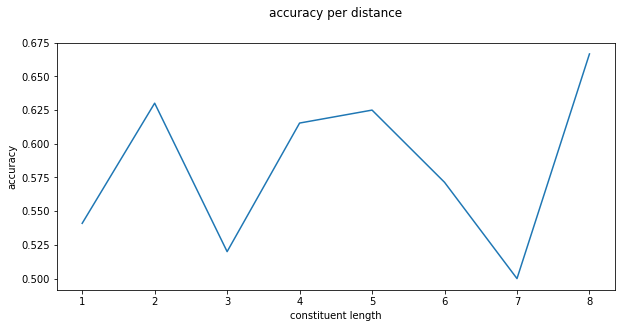

In [122]:
lens = sorted(dist_total_consts.keys())
dist_accuracy = []
for l in lens:
    if l in dist_acc_consts:
        dist_accuracy.append(dist_acc_consts.get(l)/dist_total_consts.get(l))
    else:
        dist_accuracy.append(0)

plt.figure(num=3, figsize=(10, 10))
acc_plt = plt.subplot(2 ,1, 1, xlabel="constituent length", ylabel="accuracy", label="pr")
acc_plt.set_title("accuracy per distance", y=1.08)
acc_plt.plot(lens, dist_accuracy)
plt.show()

WRITE CONCLUSIONS

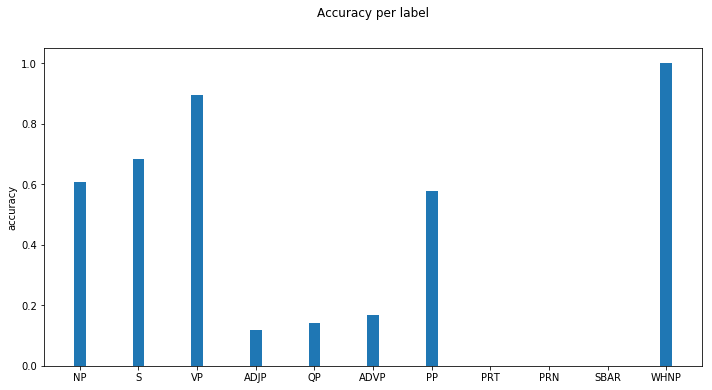

In [125]:
labels = labels_total_consts.keys()
label_accuracy = []
for l in labels:
    if l in labels_acc_consts:
        label_accuracy.append(labels_acc_consts.get(l)/labels_total_consts.get(l))
    else:
        label_accuracy.append(0)

plt.figure(num=5, figsize=(10, 10))
label_acc = plt.subplot(211)
rectangles_tr = plt.bar(range(len(labels)), label_accuracy, width=0.2)
label_acc.set_xticks(np.linspace(0, len(labels) - 1, len(labels)))
label_acc.set_xticklabels(labels, fontsize=10)
label_acc.set_ylabel('accuracy')
label_acc.set_title('Accuracy per label', y=1.08)
plt.tight_layout()
plt.show()